In [1]:
import torch
from omegaconf import DictConfig
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

import numpy as np

from tsl import logger
from tsl.data import ImputationDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import AirQuality, MetrLA, PemsBay
from tsl.engines import Imputer
from tsl.experiment import Experiment
from tsl.metrics import numpy as numpy_metrics
from tsl.metrics import torch as torch_metrics
from tsl.nn.models import (BiRNNImputerModel, GRINModel, RNNImputerModel,
                           SPINHierarchicalModel, SPINModel)
from tsl.transforms import MaskInput
from tsl.utils.casting import torch_to_numpy

from my_datasets import AirQualitySmaller, AirQualityAuckland, AirQualityKrig, add_missing_sensors
from KITS import KITS
from KITS_filler import GCNCycVirtualFiller
from unnamed_filler import UnnamedKrigFiller
from unnamedKrig import UnnamedKrigModel

from omegaconf import OmegaConf

from my_datasets import AirQualitySmaller, AirQualityAuckland, AirQualityKrig
from KITS import KITS
from KITS_filler import GCNCycVirtualFiller

import matplotlib.pyplot as plt

from torch_geometric.utils import dense_to_sparse, get_ppr
from my_datasets import AirQualitySmaller, AirQualityAuckland, AirQualityKrig, add_missing_sensors
import networkx as nx

In [2]:
def get_model_class(model_str):
    if model_str == 'rnni':
        model = RNNImputerModel
    elif model_str == 'birnni':
        model = BiRNNImputerModel
    elif model_str == 'grin':
        model = GRINModel
    elif model_str == 'spin':
        model = SPINModel
    elif model_str == 'spin-h':
        model = SPINHierarchicalModel
    elif model_str == 'kits':
        model = KITS
    elif model_str == 'unkrig':
        model = UnnamedKrigModel
    else:
        raise NotImplementedError(f'Model "{model_str}" not available.')
    return model


def get_dataset(dataset_name: str, p_fault=0., p_noise=0., t_range = ['2022-04-01', '2022-12-01'],
                masked_s=None, agg_func = 'mean', test_month=[5], location='Auckland'):
    if dataset_name == 'air':
        return AirQualityKrig(impute_nans=True, small=True, masked_sensors=masked_s, p=p_noise)
    if dataset_name == 'air_smaller':
        return AirQualitySmaller('../../AirData/AQI/Stations', impute_nans=True, masked_sensors=masked_s)
    if dataset_name == 'air_auckland' or dataset_name == 'air_invercargill1' or dataset_name == 'air_invercargill2':
        return AirQualityAuckland('../../AirData/Niwa', t_range=t_range, masked_sensors=masked_s, 
                                  agg_func=agg_func, test_months=test_month,
                                  location=location, p=p_noise)
    if dataset_name.endswith('_point'):
        p_fault, p_noise = 0., 0.25
        dataset_name = dataset_name[:-6]
    if dataset_name.endswith('_block'):
        p_fault, p_noise = 0.0015, 0.05
        dataset_name = dataset_name[:-6]
    if dataset_name == 'metrla':
        return add_missing_sensors(MetrLA(freq='5T'),
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  seed=9101112, 
                                  masked_sensors=masked_s)
    if dataset_name == 'bay':
        return add_missing_sensors(PemsBay(),
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  seed=56789,
                                  masked_sensors=masked_s)
    raise ValueError(f"Dataset {dataset_name} not available in this setting.")

In [3]:
# mask_s = [0, 4, 5, 6, 10, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 26, 29, 31, 32]
mask_s = [1, 2, 3, 7, 8, 9, 11, 12, 17, 20, 21, 25, 27, 28, 30, 33, 34, 35]
mask_s = None
# mask_s = [1, 8, 9, 21, 35]
# mask_s = [0, 5, 18, 19, 31]

dataset = get_dataset('air', p_noise=0.5, masked_s=mask_s)
# covariates = {'u': dataset.datetime_encoded('day').values}
adj = dataset.get_connectivity(method='distance', threshold=0.1, include_self=False, layout='dense', force_symmetric=True)

In [4]:
features_raw = torch.tensor(dataset.dataframe().values).T
s = features_raw.shape[0]
s

36

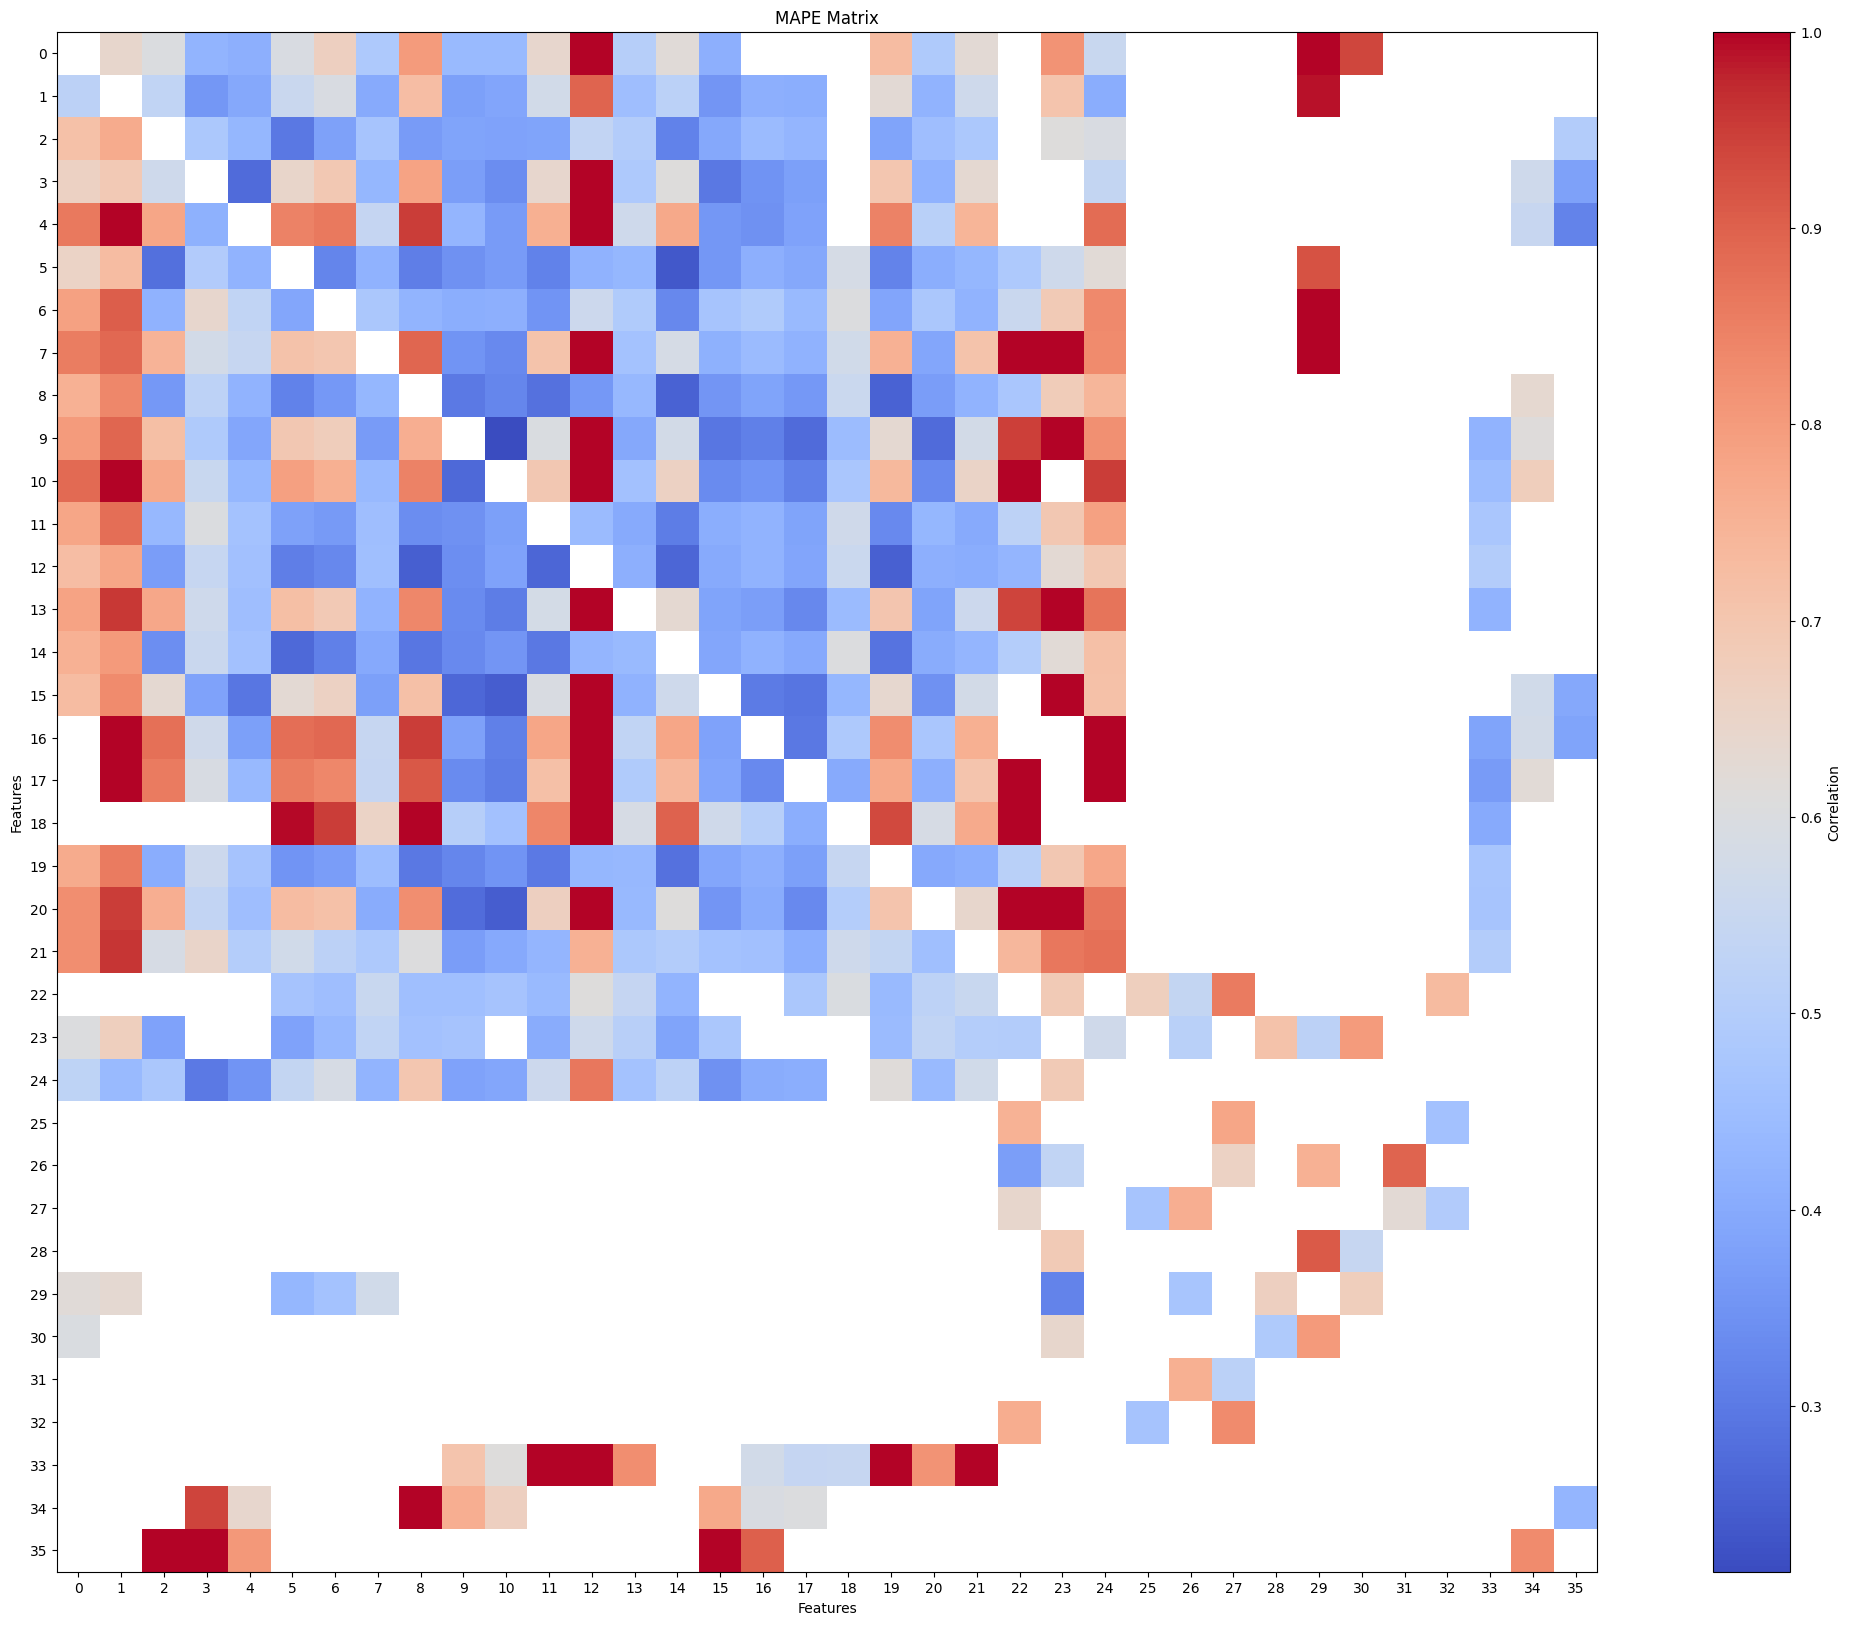

In [5]:
features_raw = torch.tensor(dataset.dataframe().values).T
# features_raw = features_raw[:, 1:] - features_raw[:, :-1]
s = features_raw.shape[0]
mape_mat = np.zeros((s, s))
for i in range(s):
    for j in range(s):
        mape_mat[i, j] = numpy_metrics.mape(features_raw[i], features_raw[j])

mape_mat = np.where(adj[:s, :s] > 0, mape_mat, np.ones_like(mape_mat)*(-np.inf))

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(mape_mat, cmap="coolwarm", interpolation="nearest", vmax=1)
plt.colorbar(label="Correlation")

# # Add text annotations
# for i in range(mape_mat.shape[0]):
#     for j in range(mape_mat.shape[1]):
#         plt.text(j, i, f"{mape_mat[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("MAPE Matrix")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(mape_mat.shape[0]))
plt.yticks(range(mape_mat.shape[1]))
plt.show()

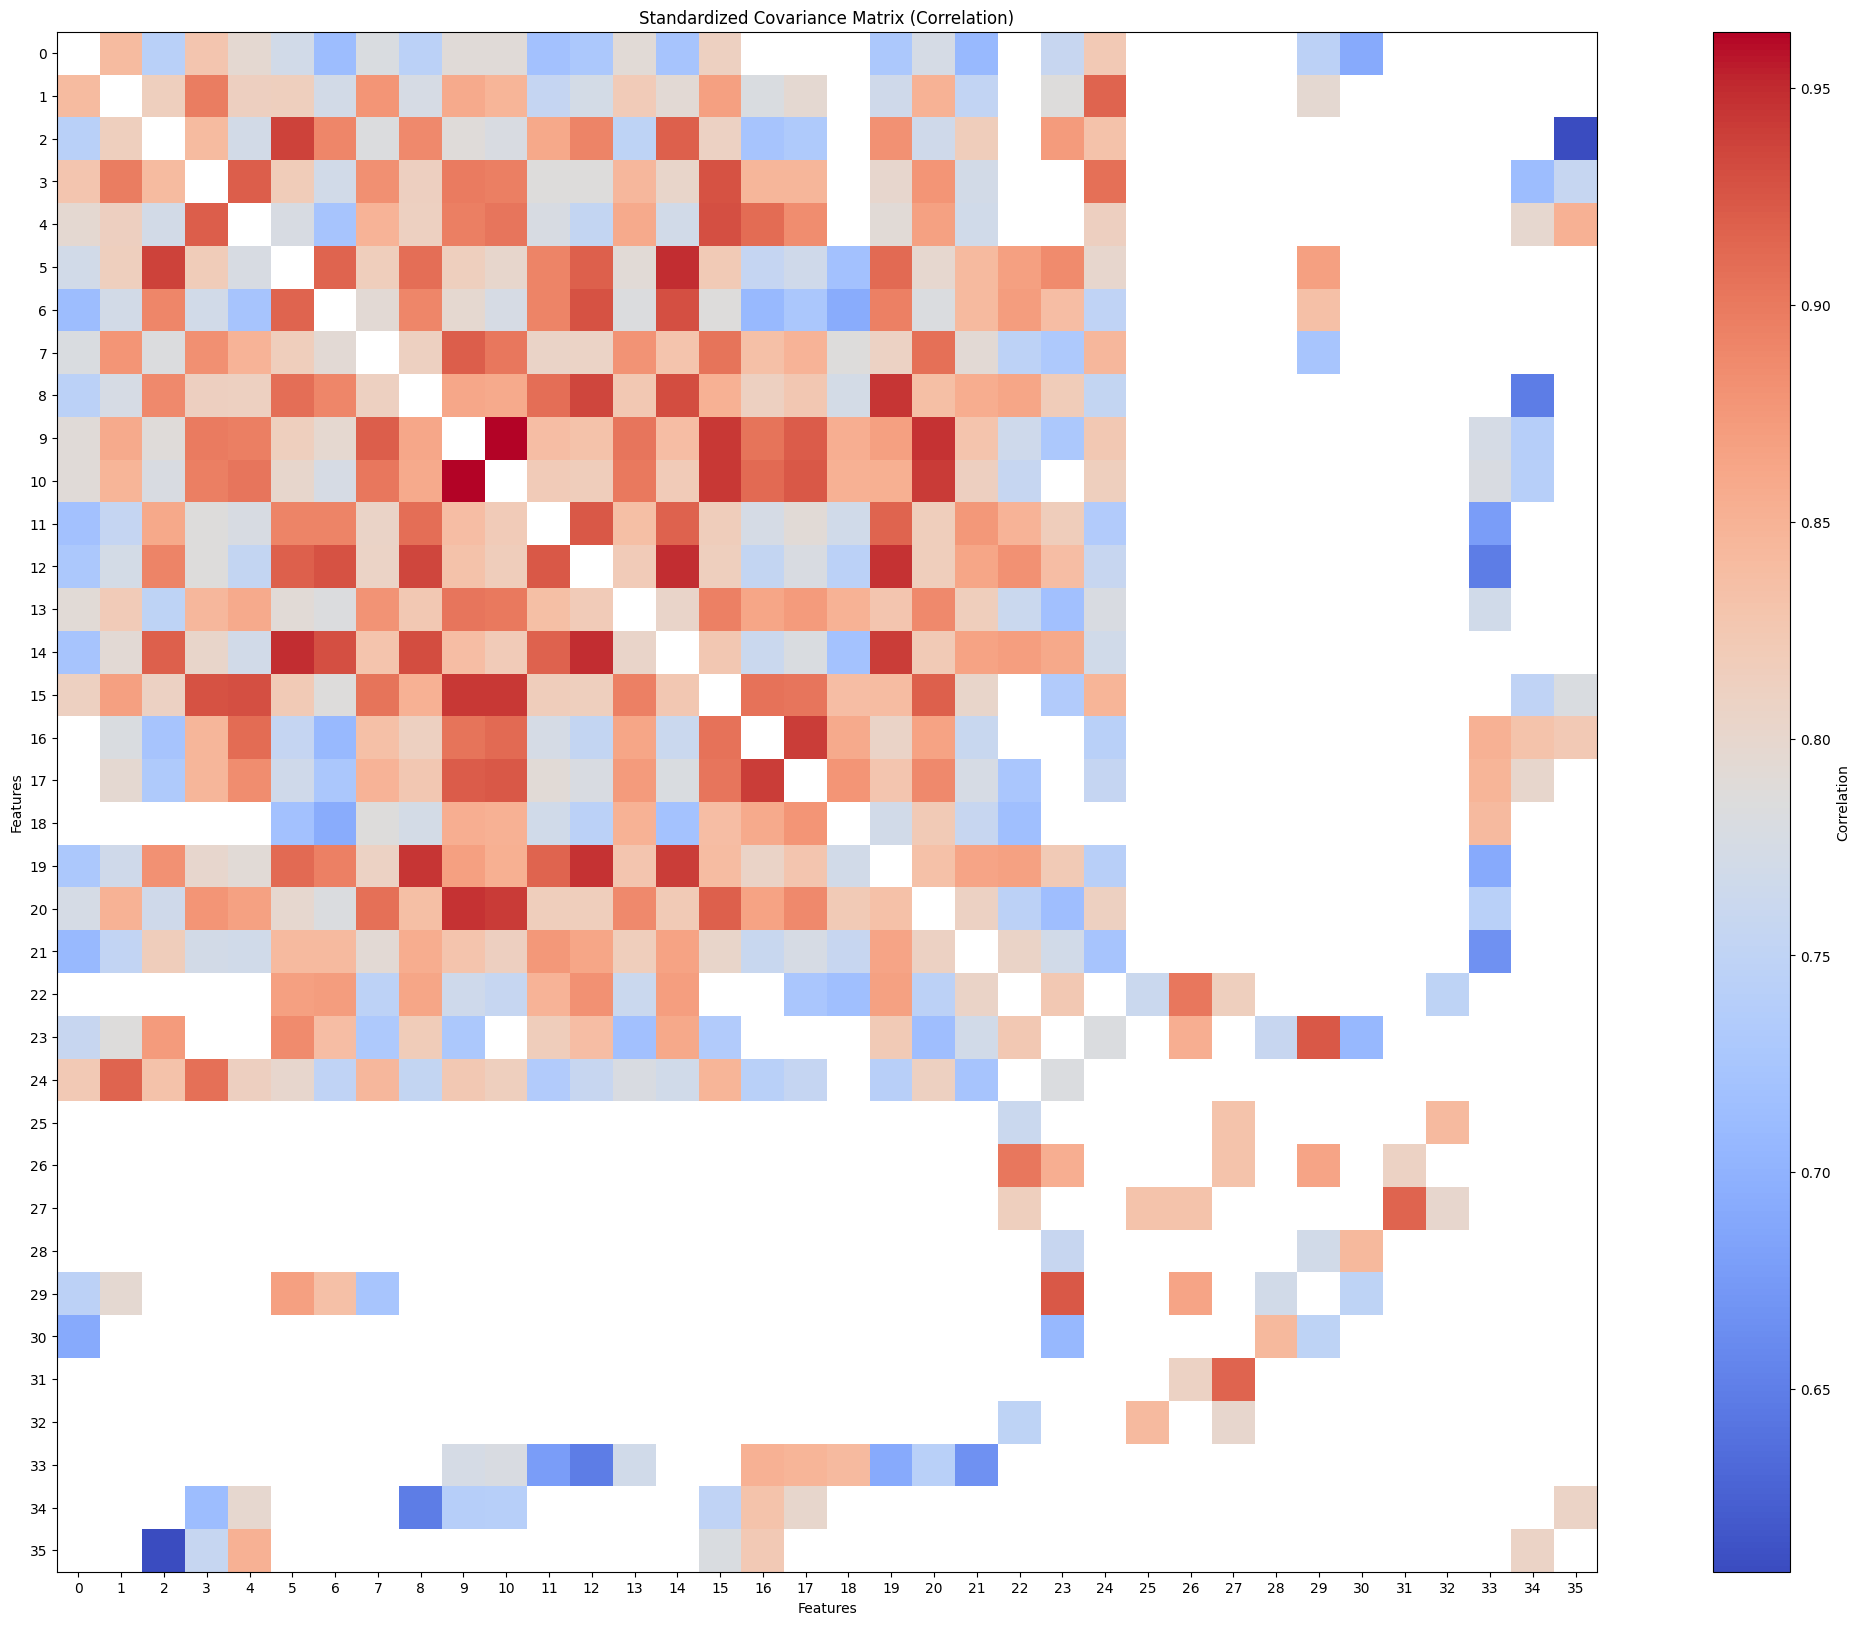

In [6]:
features_raw = torch.tensor(dataset.dataframe().values).T
cov_mat = np.cov(features_raw.T, rowvar=False, bias=False)

std_devs = np.sqrt(np.diag(cov_mat))
std_dev_outer = np.outer(std_devs, std_devs)

standardized_cov_matrix_real = np.divide(cov_mat, std_dev_outer, where=std_dev_outer != 0)

standardized_cov_matrix_real = np.where(adj > 0, standardized_cov_matrix_real, np.ones_like(standardized_cov_matrix_real)*(-np.inf))
# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(standardized_cov_matrix_real, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# # Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Standardized Covariance Matrix (Correlation)")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(standardized_cov_matrix_real.shape[0]))
plt.yticks(range(standardized_cov_matrix_real.shape[1]))
plt.show()

In [7]:
features_raw_diff = features_raw[:, 2:] - features_raw[:, :-2]

In [8]:
cov_mat = np.cov(features_raw_diff.T, rowvar=False, bias=False)

std_devs = np.sqrt(np.diag(cov_mat))
std_dev_outer = np.outer(std_devs, std_devs)

standardized_cov_matrix = np.divide(cov_mat, std_dev_outer, where=std_dev_outer != 0)

In [9]:
standardized_cov_matrix = np.where(adj > 0, standardized_cov_matrix, np.zeros_like(standardized_cov_matrix))

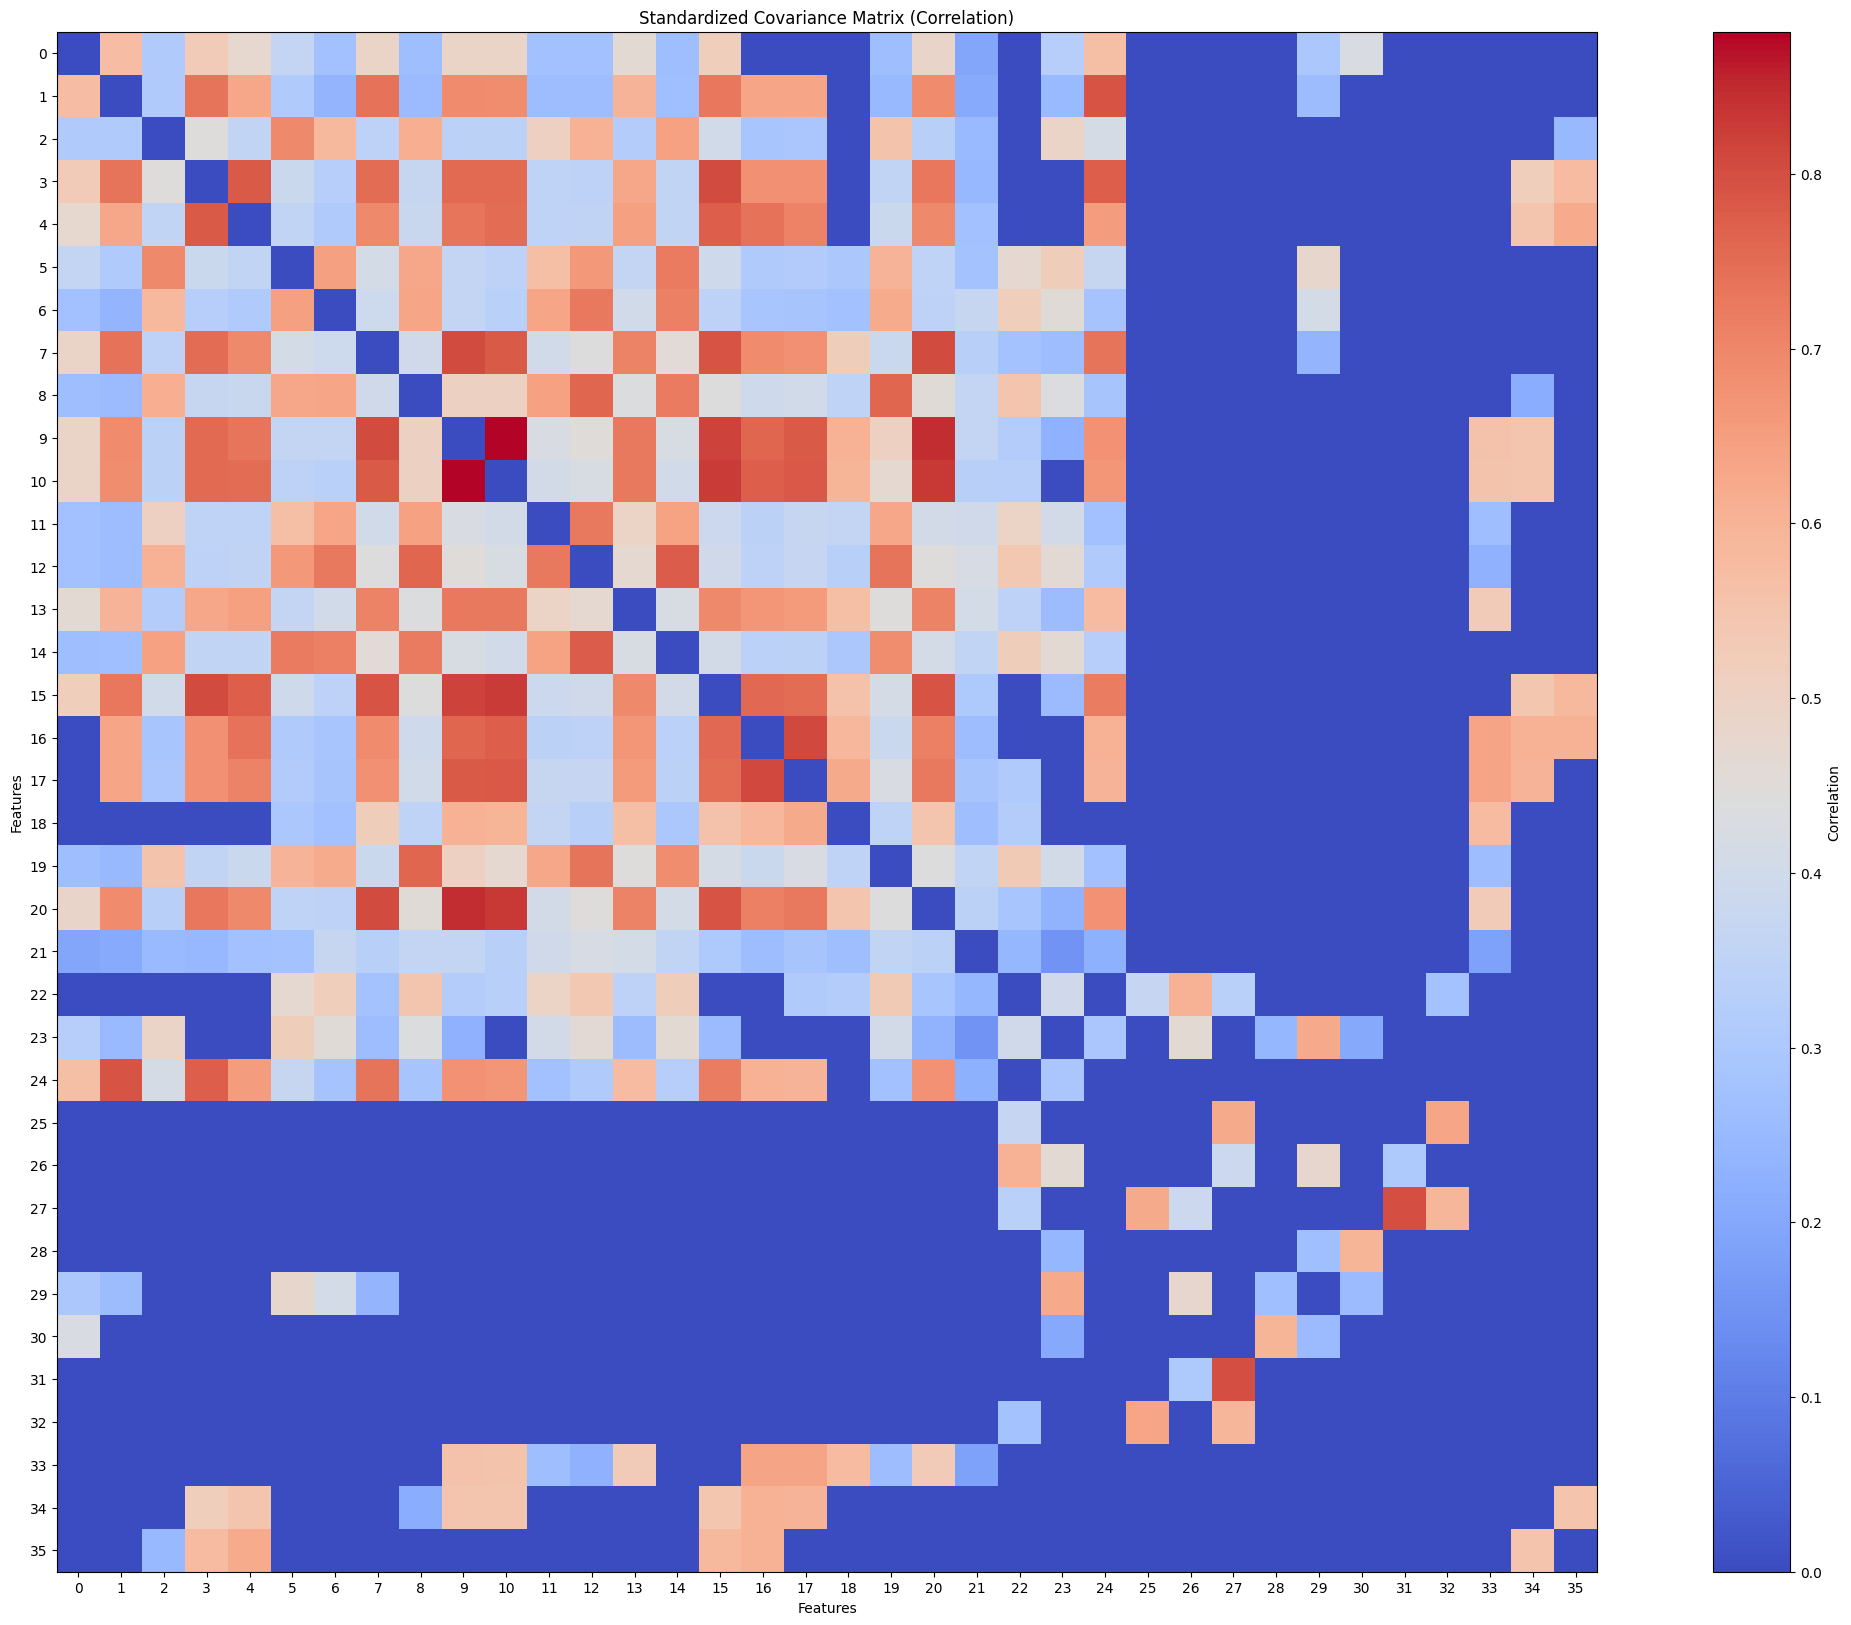

In [10]:
# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(standardized_cov_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# # Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Standardized Covariance Matrix (Correlation)")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(standardized_cov_matrix.shape[0]))
plt.yticks(range(standardized_cov_matrix.shape[1]))
plt.show()

In [11]:
adj

array([[0.        , 0.8685382 , 0.58219194, ..., 0.        , 0.        ,
        0.        ],
       [0.8685382 , 0.        , 0.86604404, ..., 0.        , 0.        ,
        0.        ],
       [0.58219194, 0.86604404, 0.        , ..., 0.        , 0.        ,
        0.10112431],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.3707812 ],
       [0.        , 0.        , 0.10112431, ..., 0.        , 0.3707812 ,
        0.        ]], dtype=float32)

In [12]:
from torch_geometric.utils import get_ppr

sparse_adj = dense_to_sparse(torch.tensor(adj))
get_ppr(sparse_adj[0], num_nodes=207, target=torch.tensor([0, 1]))

(tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
           1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
         [ 0, 10, 34, 35, 33, 22, 32, 27, 26, 25, 18, 17, 16,  9, 31,  8,  7,  6,
           5,  4,  3, 12, 11, 13, 14, 15, 19, 20, 21, 23, 28, 24, 29, 30,  1,  2,
           1, 11, 33, 22, 32, 27, 26, 25, 18, 10, 34, 35, 31,  9,  8,  7,  6,  5,
           4,  3,  2,  0, 30, 28, 12, 14, 15, 16, 17, 19, 20, 21, 23, 24, 29, 13]]),
 tensor([0.2245, 0.0310, 0.0083, 0.0056, 0.0103, 0.0177, 0.0015, 0.0027, 0.0043,
         0.0015, 0.0171, 0.0230, 0.0231, 0.0321, 0.0011, 0.0313, 0.0322, 0.0321,
         0.0322, 0.0295, 0.0294, 0.0314, 0.0313, 0.0313, 0.0306, 0.0314, 0.0314,
         0.0313, 0.0313, 0.0312, 0.0052, 0.0291, 0.0180, 0.0123, 0.0307, 0.0298,
         0.2237,

In [13]:
sparse_adj[0][:, 10]

tensor([ 0, 11])

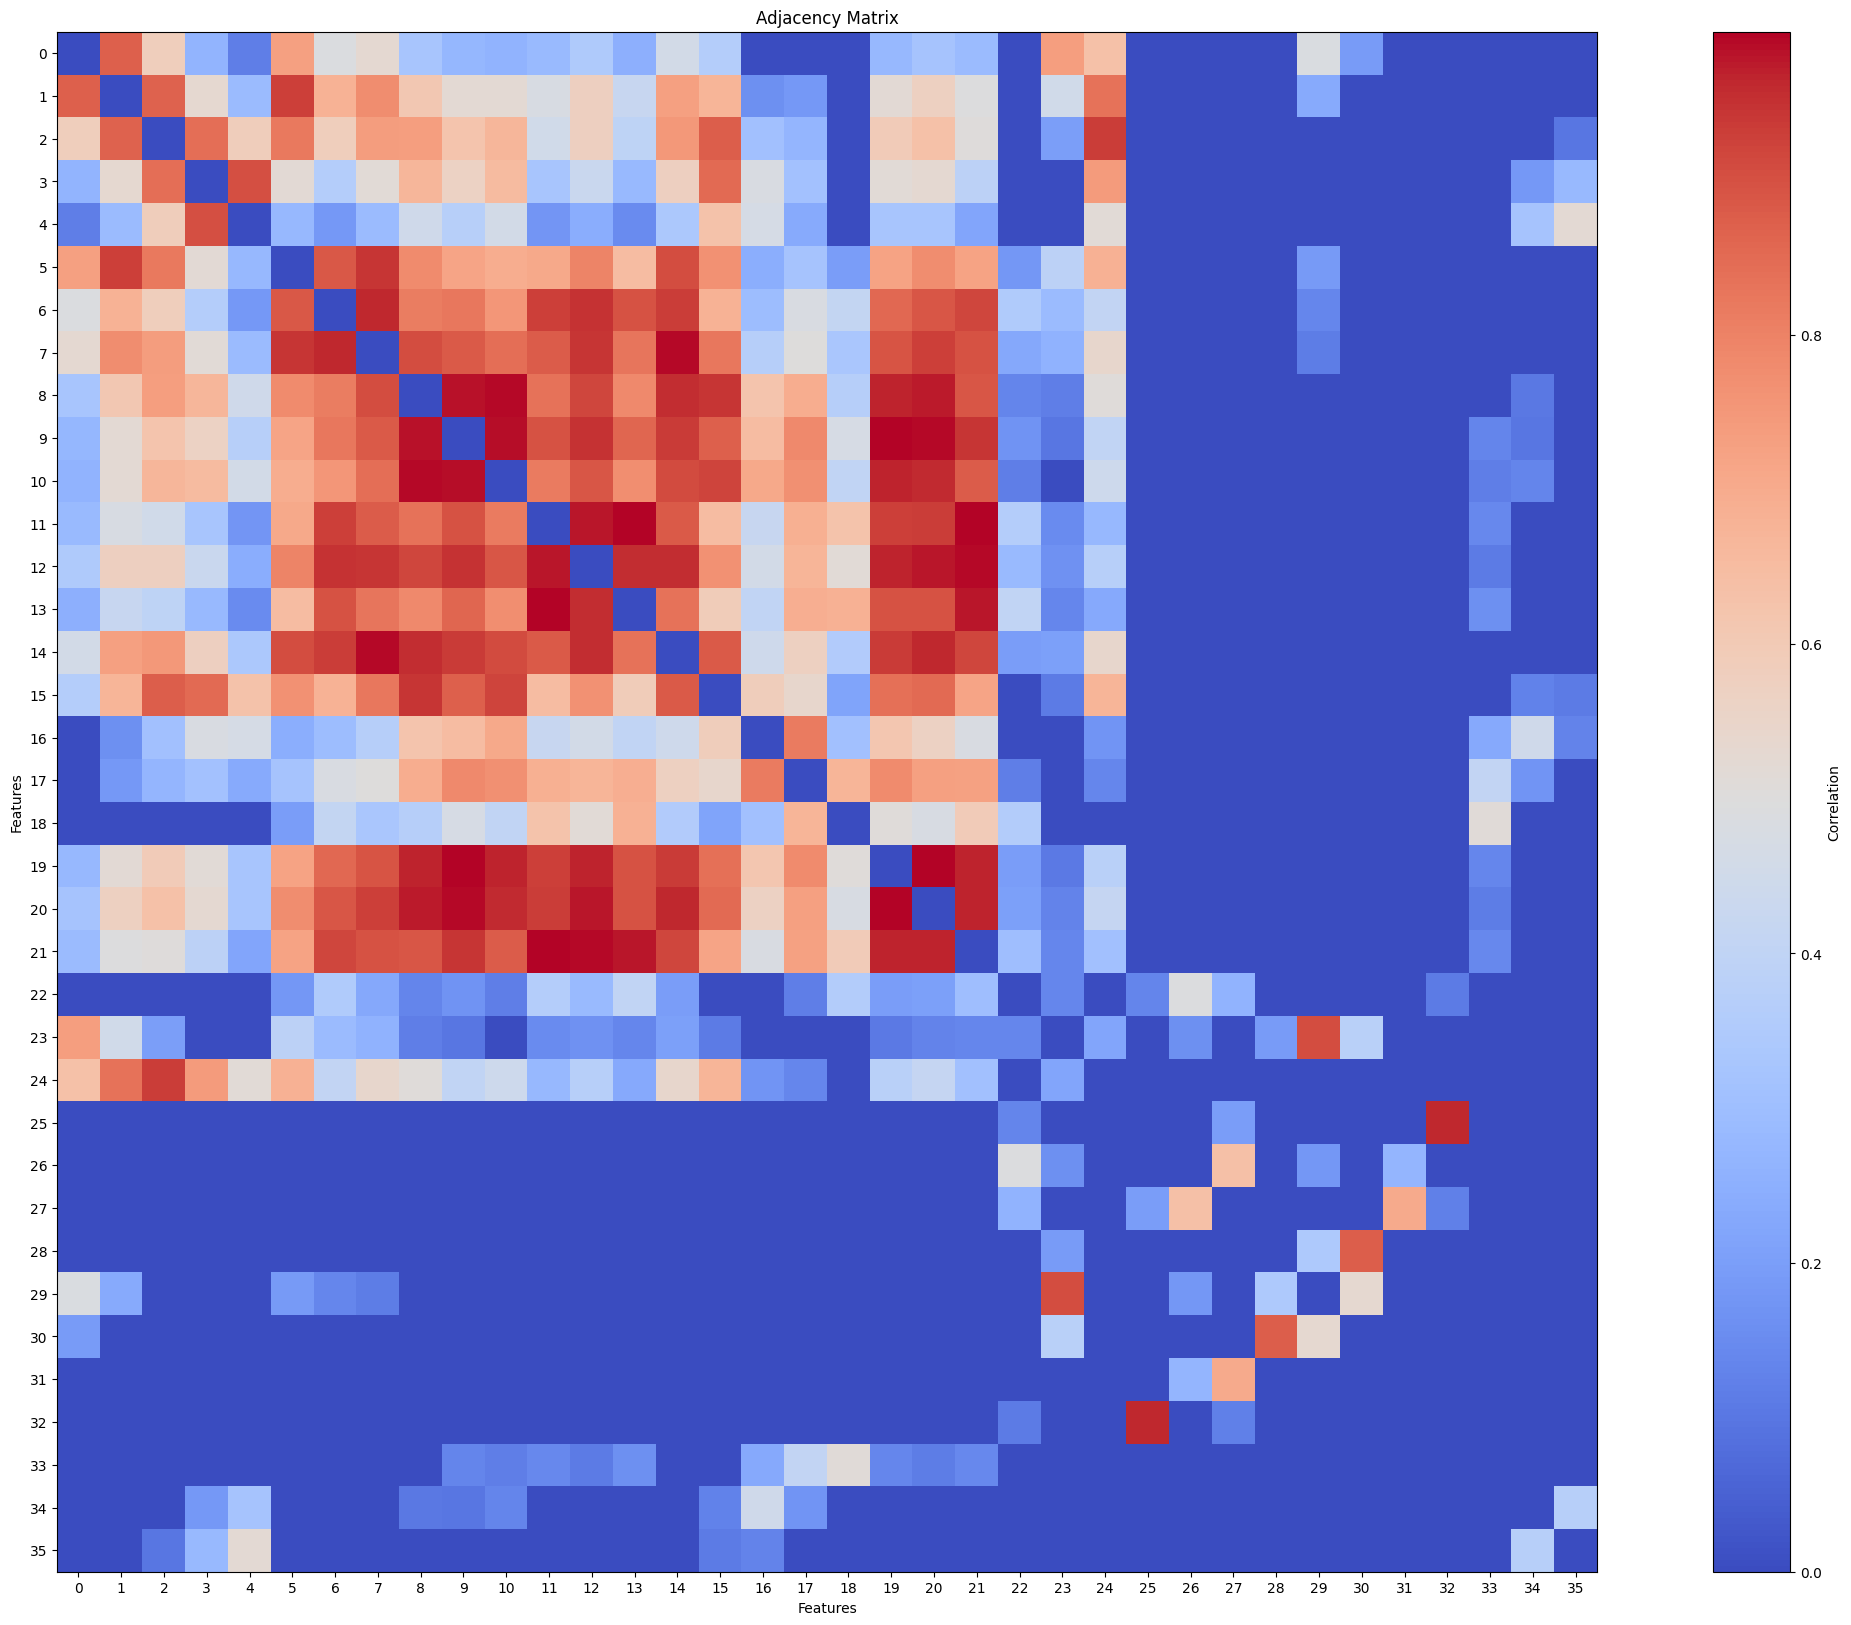

In [14]:
adj

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(adj, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# # Add text annotations
# for i in range(adj.shape[0]):
#     for j in range(adj.shape[1]):
#         plt.text(j, i, f"{adj[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Adjacency Matrix")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(adj.shape[0]))
plt.yticks(range(adj.shape[1]))
plt.show()

In [15]:
def centering(M):
    """
    Calculate the centering matrix
    """
    n = M.shape[0]
    unit = np.ones([n, n])
    identity = np.eye(n)
    H = identity - unit/n

    return np.matmul(M, H)

def gaussian_grammat(x, sigma=None):
    """
    Calculate the Gram matrix of x using a Gaussian kernel.
    If the bandwidth sigma is None, it is estimated using the median heuristic:
    ||x_i - x_j||**2 = 2 sigma**2
    """
    try:
        x.shape[1]
    except IndexError:
        x = x.reshape(x.shape[0], 1)

    xxT = np.matmul(x, x.T)
    xnorm = np.diag(xxT) - xxT + (np.diag(xxT) - xxT).T
    if sigma is None:
        mdist = np.median(xnorm[xnorm!= 0])
        sigma = np.sqrt(mdist*0.5)


   # --- If bandwidth is 0, add machine epsilon to it
    if sigma==0:
        eps = 7./3 - 4./3 - 1
        sigma += eps

    KX = - 0.5 * xnorm / sigma / sigma
    np.exp(KX, KX)
    return KX

def dHSIC_calc(K_list):
    """
    Calculate the HSIC estimator in the general case d > 2, as in
    [2] Definition 2.6
    """
    if not isinstance(K_list, list):
        K_list = list(K_list)

    n_k = len(K_list)

    length = K_list[0].shape[0]
    term1 = 1.0
    term2 = 1.0
    term3 = 2.0/length

    for j in range(0, n_k):
        K_j = K_list[j]
        term1 = np.multiply(term1, K_j)
        term2 = 1.0/length/length*term2*np.sum(K_j)
        term3 = 1.0/length*term3*K_j.sum(axis=0)

    term1 = np.sum(term1)
    term3 = np.sum(term3)
    dHSIC = (1.0/length)**2*term1+term2-term3
    return dHSIC

def HSIC(x, y):
    """
    Calculate the HSIC estimator for d=2, as in [1] eq (9)
    """
    n = x.shape[0]
    return np.trace(np.matmul(centering(gaussian_grammat(x)),centering(gaussian_grammat(y))))/n/n

In [16]:
split_tens = features_raw[:, features_raw.shape[1]%24:]
split_tens = split_tens.view(36, 24, -1)
split_tens = split_tens.numpy()

hsic_mat = np.zeros((36, 36))
for i in range(36):
    for j in range(36):
        hsic_mat[i, j] = HSIC(split_tens[i], split_tens[j])

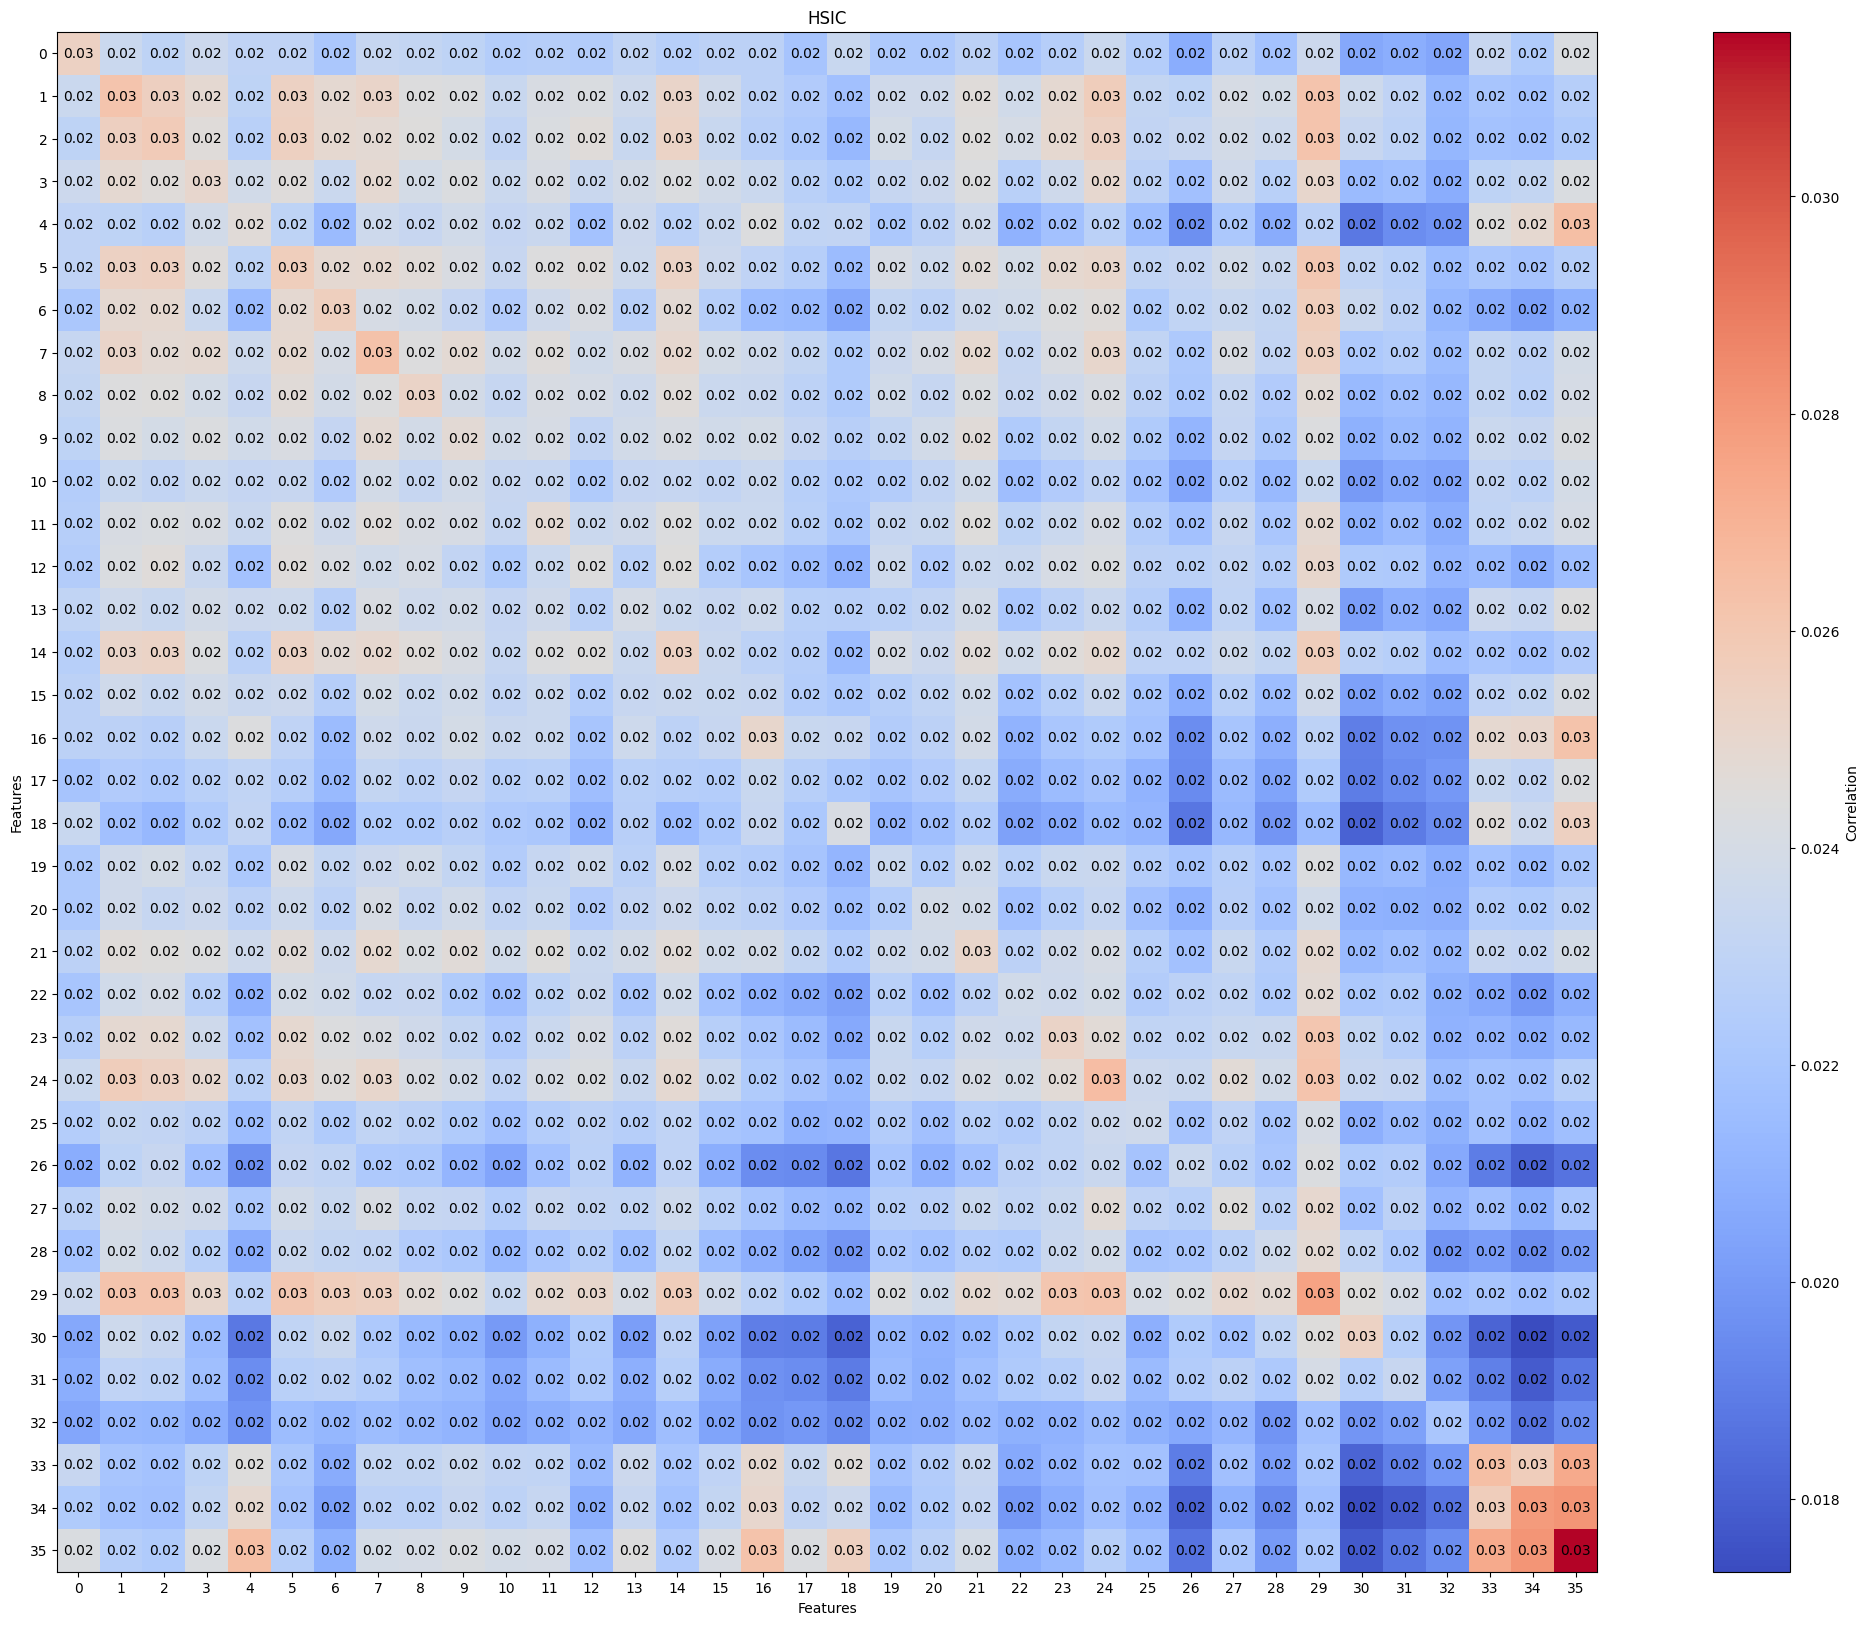

In [17]:
# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(hsic_mat, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# Add text annotations
for i in range(hsic_mat.shape[0]):
    for j in range(hsic_mat.shape[1]):
        plt.text(j, i, f"{hsic_mat[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("HSIC")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(hsic_mat.shape[0]))
plt.yticks(range(hsic_mat.shape[1]))
plt.show()

In [18]:
import scipy as sc

sc.special.kl_div(split_tens[0], split_tens[1])

array([[5.46436191e-01, 6.42117357e+00, 3.02953458e+00, ...,
        9.65082765e-01, 1.11647375e-01, 6.61836714e-02],
       [2.62479186e+00, 3.31602240e+00, 5.87522268e-01, ...,
        1.87592804e-01, 1.04145980e+00, 2.68031740e+00],
       [2.34336162e+00, 1.45637905e-02, 2.33182997e-01, ...,
        1.49714553e+00, 2.10320759e+00, 2.06901450e-02],
       ...,
       [5.20627052e-02, 0.00000000e+00, 5.42705990e-02, ...,
        1.24149680e-01, 1.25886515e-01, 3.97271603e-01],
       [1.24149807e-01, 3.58105730e-03, 1.07082650e-02, ...,
        2.83432770e+00, 5.75487375e+00, 6.24970436e+00],
       [3.35421448e+01, 3.19357085e+00, 7.03008461e+00, ...,
        2.36923322e-01, 6.06211185e-01, 2.40084499e-01]], dtype=float32)

In [19]:
np.sum(adj, axis=0)

array([ 9.088894  , 12.929548  , 13.614525  , 11.728188  ,  8.405075  ,
       15.538291  , 15.948598  , 16.913576  , 17.068958  , 16.987572  ,
       16.636425  , 15.802106  , 16.785465  , 15.139157  , 17.165693  ,
       16.049978  , 10.396038  , 12.2656145 ,  8.017573  , 16.889717  ,
       17.124166  , 16.363752  ,  4.750866  ,  5.6822977 , 10.365464  ,
        1.2952666 ,  1.7424606 ,  1.9209096 ,  1.4087799 ,  3.1234007 ,
        1.9703113 ,  0.97192276,  1.195891  ,  2.2181158 ,  1.9687777 ,
        1.5191394 ], dtype=float32)

In [20]:
# mask_s= [ 40,  43,  79,  22, 117, 125, 103, 141, 138, 136, 197, 127, 111, 32,  91,  77,  68,  71,  20,  19,  42,  24,   3,  15,   5,  28, 17, 142, 206, 191, 144,  96, 119,  27,  72,  82,   0,  33,  13, 157, 146, 193, 196, 102,  85,  97, 171, 192, 128, 161,   7, 159, 190, 162, 132, 198, 166, 175, 155, 187,  80,   4, 195, 163, 160, 12, 188, 154,  16]
# mask_s= [172, 167, 137,  14,  49, 107, 105,  87,  73, 122, 115,  89, 139, 179,  67,  70,  76, 109,  69,   6,  63,  60, 140, 158, 199, 205, 204,  30,  78, 169, 131, 123, 118,   2, 177, 133, 110,  74,  95, 84,  57, 176,  41, 151, 145,  54,  58,  37,  39, 113, 101,  88, 108,  98,  53,  48,  11,   1, 114, 130, 135, 173, 178, 168,  93, 94,  81,  55,  38]
# mask_s= [26, 126, 149,  66, 182, 203,  51,  90, 112,  99, 200, 194, 181, 121,  46, 120, 150, 180,  18,  21,  23, 153, 189, 202,  65,  61, 31, 174, 147,  50,  56,  59,  29, 186, 184,  52,  83,   8, 165, 86,  34,  44,  45,  25, 35, 185, 152, 156, 116, 124,  92, 104, 134, 100, 106,  36, 148, 183,  75,  64,  10,   9,  62,  47, 129, 143, 164, 170, 201]
# mask_s= [149,  10, 156,  90, 183,  64,  66,  55,  31, 118, 107,  99,  46, 27, 105, 179,   7,  65,  92,  11,  30, 171, 109, 184, 152, 177, 123, 135,   1,  53, 170,  89, 112, 173, 108,  28,  78, 132, 110, 153,  29,  44,  71,  62, 106,  67,  49, 129,  48,  85, 125, 122, 202, 167,  79, 178, 104, 196, 139, 194,   2, 166, 201,  58,  45, 114,  51,  96, 147]
mask_s = range(12)

known_set = [i for i in range(adj.shape[0]) if i not in mask_s]
print(known_set)

g1_adj = adj
g1_adj = g1_adj[known_set, :]
g1_adj = g1_adj[:, known_set]
g1_x = torch.ones((g1_adj.shape[0], 1))/g1_adj.shape[0]

nx_g1 = nx.from_numpy_array(g1_adj)
nx.set_node_attributes(nx_g1, {ind:val for ind, val in enumerate(known_set)}, 'label')

g2_adj = adj
g2_adj = g2_adj[mask_s, :]
g2_adj = g2_adj[:, mask_s]
g2_x = torch.ones((g2_adj.shape[0], 1))/g2_adj.shape[0]

nx_g2 = nx.from_numpy_array(g2_adj)
nx.set_node_attributes(nx_g2, {ind:val for ind, val in enumerate(mask_s)}, 'label')

g3_adj = adj
g3_x = torch.ones((g3_adj.shape[0], 1))/g3_adj.shape[0]

nx_g3 = nx.from_numpy_array(g3_adj)
nx.set_node_attributes(nx_g3, {i:i for i in range(36)}, 'label')

[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


In [21]:
g1_adj.shape, len(known_set)

((24, 24), 24)

In [22]:
from networkx.algorithms import approximation

approximation.average_clustering(nx_g1), approximation.average_clustering(nx_g2), approximation.average_clustering(nx_g3)

(0.829, 1.0, 0.829)

In [23]:
degree_sequence_g1 = sorted((d for n, d in nx_g1.degree()), reverse=True)
degree_sequence_g2 = sorted((d for n, d in nx_g3.degree() if n in mask_s), reverse=True)
degree_sequence_g3 = sorted((d for n, d in nx_g3.degree()), reverse=True)

In [24]:
import random
from torch.nn.functional import kl_div

class GraphStorage:
    def __init__(self, max_size, measure='random', distance_metric='euclidean'):
        self.adj_storage = [] # Fixed-size queue
        self.tensor_storage = []
        self.max_size = max_size
        self.measure = measure
        self.distance_metric = distance_metric
        self.distance_matrix = torch.empty((0, 0))

    def add_tensor(self, adj, new_tensor):
        """Adds a tensor, replacing the most redundant one if full."""
        if len(self.tensor_storage) < self.max_size:
            self.adj_storage.append(adj)
            self.tensor_storage.append(new_tensor)
            self._update_distance_matrix()
        else:
            new_distances = torch.tensor([self._distance(new_tensor, t) for t in self.tensor_storage])

            # Compute distances
            avg_distances = self.distance_matrix.mean(dim=1)
            new_tensor_avg_dist = new_distances.mean()

            # Find the most redundant tensor (smallest avg distance)
            min_dist_idx = avg_distances.argmin().item()

            # Replace if the new tensor has a higher avg distance
            if new_tensor_avg_dist > avg_distances[min_dist_idx]:
                self.adj_storage[min_dist_idx] = adj
                self.tensor_storage[min_dist_idx] = new_tensor  # Replace tensor
                self.distance_matrix[min_dist_idx, :] = new_distances
                self.distance_matrix[:, min_dist_idx] = new_distances

    def get_random_tensor(self):
        """Returns a random tensor from storage."""
        if not self.adj_storage:
            raise ValueError("Storage is empty!")
        
        match self.measure:
            case 'random':
                return random.choice(self.adj_storage)
        raise Exception('Invalid measure')

    def _average_distance(self, tensor):
        """Computes the average distance of a tensor to all stored tensors."""
        if not self.tensor_storage:
            return float('inf')  # If storage is empty, return a high value
        distances = [self._distance(tensor, t) for t in self.tensor_storage]
        return sum(distances) / len(distances)

    def _update_distance_matrix(self):
        """Recomputes the full distance matrix when a new tensor is added."""
        num_tensors = len(self.tensor_storage)
        new_matrix = torch.zeros((num_tensors, num_tensors))

        for i in range(num_tensors):
            for j in range(i + 1, num_tensors):  # Compute only upper triangle
                dist = self._distance(self.tensor_storage[i], self.tensor_storage[j])
                new_matrix[i, j] = dist
                new_matrix[j, i] = dist  # Symmetric matrix

        self.distance_matrix = new_matrix

    def _distance(self, t1, t2):
        t1, t2 = self._pad_to_same_size(t1, t2)  # Ensure equal size

        """Computes distance between two tensors."""
        if self.distance_metric == "euclidean":
            return torch.norm(t1 - t2).item()
        elif self.distance_metric == "cosine":
            return 1 - torch.nn.functional.cosine_similarity(t1, t2, dim=0).mean().item()
        elif self.distance_metric == 'kl':
            return kl_div(t1, t2, reduction='mean')
        else:
            raise ValueError("Unsupported distance metric")
    
    def _pad_to_same_size(self, t1, t2):
        """Pads the smaller tensor with zeros to match the larger tensor's size."""
        size1, size2 = t1.shape[-1], t2.shape[-1]
        if size1 < size2:
            t1 = torch.cat([t1, torch.zeros(size2 - size1, device=t1.device)])
        elif size2 < size1:
            t2 = torch.cat([t2, torch.zeros(size1 - size2, device=t2.device)])
        return t1, t2

In [25]:
def degree_distribution(adj_matrix):
    """Computes the degree distribution from an adjacency matrix."""
    adj_matrix = torch.where(adj_matrix > 0, torch.ones_like(adj_matrix), torch.zeros_like(adj_matrix))
    degrees = adj_matrix.sum(dim=1)  # Sum rows for undirected graph
    
    max_degree = int(degrees.max().item()) # Find the highest degree
    all_bins = torch.arange(max_degree + 1)  # Create bins from 0 to max degree

    # Count occurrences of each degree, filling missing degrees with zero counts
    degree_counts = torch.zeros(max_degree + 1, dtype=torch.long)
    unique_degrees, counts = torch.unique(degrees, return_counts=True)
    unique_degrees = unique_degrees.to(dtype=torch.long)
    degree_counts[unique_degrees] = counts  # Assign counts to correct bins

    # Normalize to get probability distribution
    distribution = degree_counts / degree_counts.sum()

    return all_bins, distribution

g3_adj = torch.tensor(g3_adj)
degree_distribution(torch.tensor(g3_adj))

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26]),
 tensor([0.0000, 0.0000, 0.0278, 0.0833, 0.0278, 0.0556, 0.0278, 0.0000, 0.0000,
         0.0556, 0.0000, 0.0278, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0278, 0.0000, 0.0278, 0.0000, 0.0833, 0.1111, 0.0833, 0.3333, 0.0278]))

In [26]:
g3_adj = torch.tensor(g3_adj)
torch.where(g3_adj > 0, torch.ones_like(g3_adj), torch.zeros_like(g3_adj))

tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 1., 0.]])

In [27]:
def degree_probs(graph):
    degrees = [d for _, d in graph.degree()]  # Get degrees of all nodes
    # max_degree = max(degrees)  # Maximum degree in the graph
    degree_counts = np.bincount(degrees)  # Count occurrences of each degree
    probabilities = degree_counts / sum(degree_counts)  # Normalize to get probabilities
    return torch.tensor(probabilities, dtype=torch.float32) 

degree_probs(nx_g3)

tensor([0.0000, 0.0000, 0.0278, 0.0833, 0.0278, 0.0556, 0.0278, 0.0000, 0.0000,
        0.0556, 0.0000, 0.0278, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0278, 0.0000, 0.0278, 0.0000, 0.0833, 0.1111, 0.0833, 0.3333, 0.0278])

In [28]:
# from scipy.special import kl_div
from torch.nn.functional import kl_div

g1_p = degree_probs(nx_g1)
g3_q = degree_probs(nx_g3)

# padding_n = max(g1_p.shape[0], g3_q.shape[0]) - min(g1_p.shape[0], g3_q.shape[0])
# if g3_q.shape[0] > g1_p.shape[0]:
#     g1_p = torch.cat((g1_p, torch.zeros(padding_n)), dim=0)
# else:
#     g3_q = torch.cat((g3_q, torch.zeros(padding_n)), dim=0)

print(g1_p, g1_p)
kl_div(g1_p, g1_p, reduction='mean')

tensor([0.0000, 0.0000, 0.0417, 0.2083, 0.0833, 0.0833, 0.0000, 0.0000, 0.0417,
        0.0000, 0.0417, 0.0417, 0.0417, 0.4167]) tensor([0.0000, 0.0000, 0.0417, 0.2083, 0.0833, 0.0833, 0.0000, 0.0000, 0.0417,
        0.0000, 0.0417, 0.0417, 0.0417, 0.4167])


tensor(-0.1434)

In [29]:
# from scipy.special import kl_div
from torch.nn.functional import kl_div

g1_p = degree_probs(nx_g1)
g3_q = degree_probs(nx_g3)

storage = GraphStorage(5, distance_metric='kl')
storage.add_tensor(g1_adj, g1_p)
storage.add_tensor(g3_adj, g3_q)
storage.add_tensor(g1_adj, g1_p)
storage.add_tensor(g1_adj, g1_p)
storage.add_tensor(g1_adj, g1_p)
storage.add_tensor(g1_adj, g1_p)
storage.add_tensor(g3_adj, g3_q)

In [30]:
g1_adj.shape

(24, 24)

In [31]:
storage.get_random_tensor().shape

(24, 24)

<BarContainer object of 14 artists>

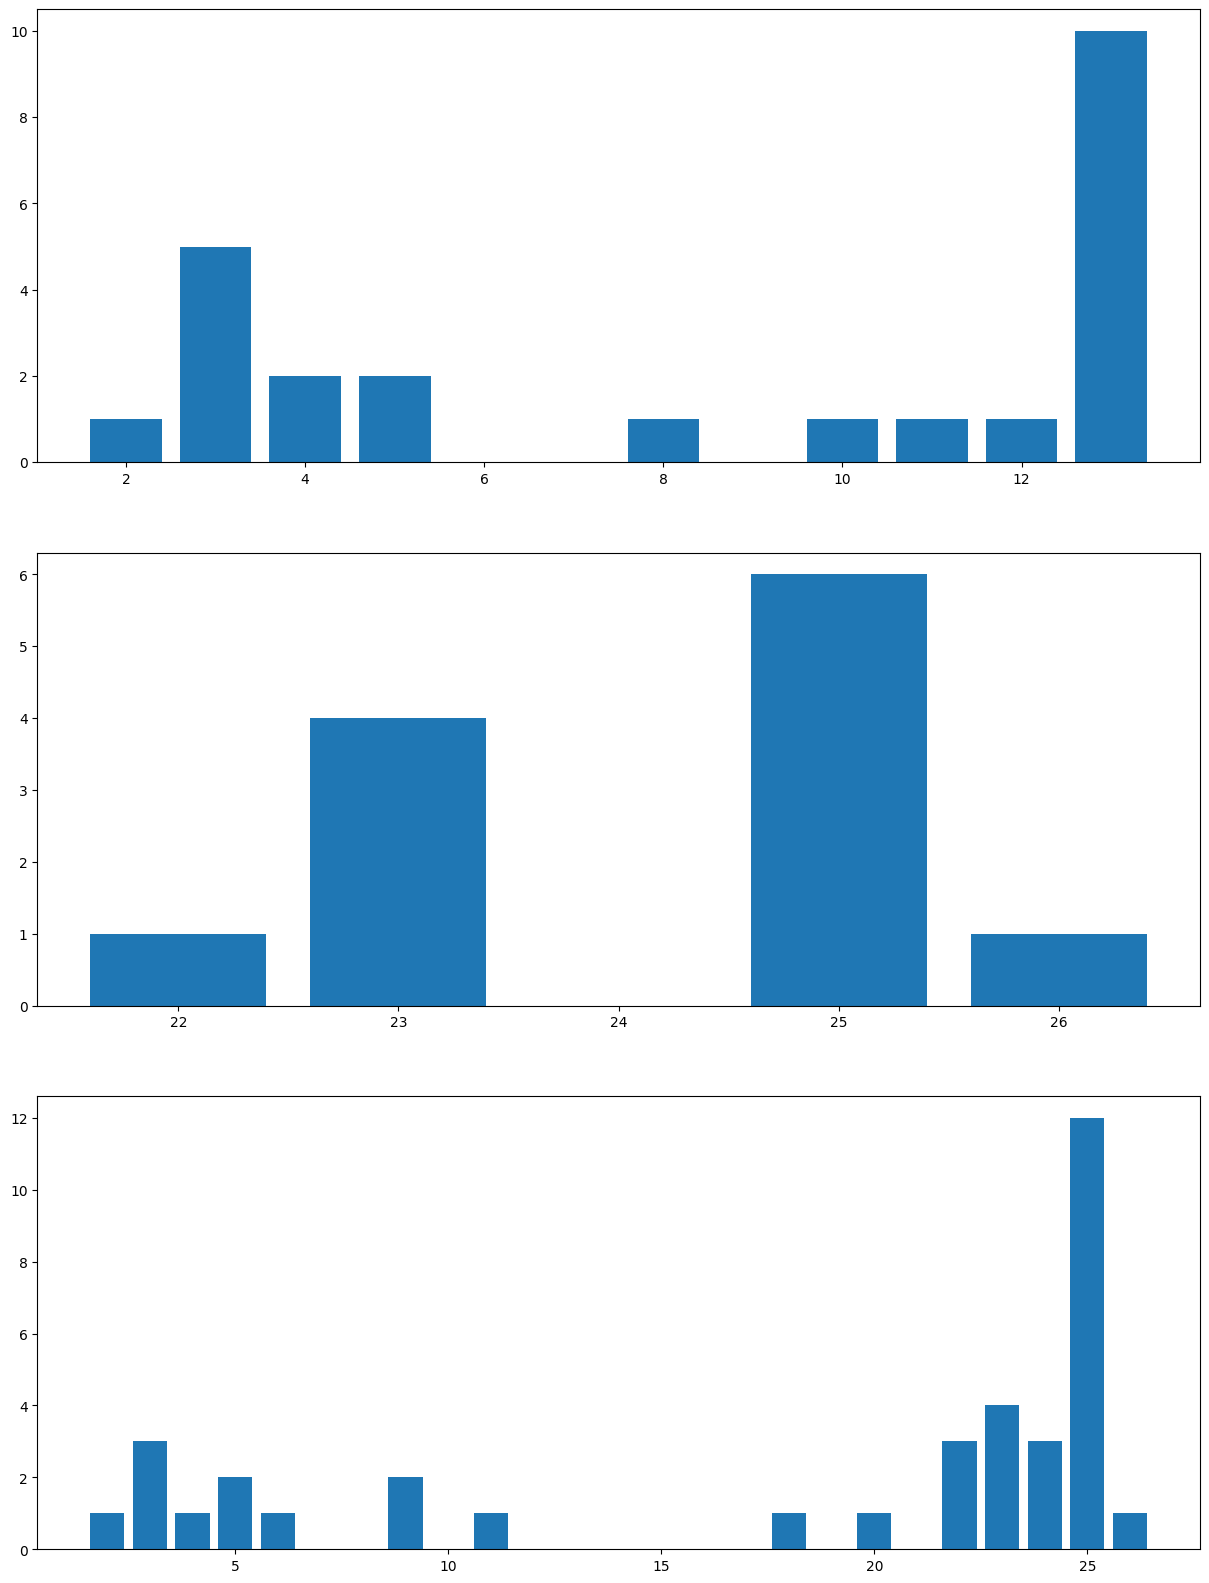

In [32]:
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

axes[0].bar(*np.unique(degree_sequence_g1, return_counts=True))
axes[1].bar(*np.unique(degree_sequence_g2, return_counts=True))
axes[2].bar(*np.unique(degree_sequence_g3, return_counts=True))

In [33]:
adj_ind = dataset.get_connectivity(method='distance', threshold=0.1, include_self=False)[0]
adj_ind = torch.tensor(adj_ind)
# get_ppr(adj_ind)

In [34]:
nx_g3

In [35]:
nx.link_analysis.pagerank(nx_g3)

{0: 0.02583367283292442,
 1: 0.03216919917905729,
 2: 0.032970521596060905,
 3: 0.02963273140716846,
 4: 0.02348807567937989,
 5: 0.037616335693889995,
 6: 0.03838386465637409,
 7: 0.04012379250041945,
 8: 0.040034135702213126,
 9: 0.040033932108911,
 10: 0.03918392222221728,
 11: 0.037748585488838575,
 12: 0.03964178102035922,
 13: 0.03645128476559999,
 14: 0.04023440446901338,
 15: 0.038096107995082236,
 16: 0.02711871250050351,
 17: 0.0305382892014395,
 18: 0.021853156444399183,
 19: 0.03969327281326134,
 20: 0.040190587186199035,
 21: 0.03880045516598553,
 22: 0.021816507800274908,
 23: 0.022309151337951694,
 24: 0.026057093828363076,
 25: 0.01885064697193274,
 26: 0.01706776748482111,
 27: 0.022772121298200748,
 28: 0.01190415808732134,
 29: 0.017078870275510152,
 30: 0.014612711401810483,
 31: 0.013491541540990533,
 32: 0.017754512117736897,
 33: 0.008877766826047063,
 34: 0.009338193472991849,
 35: 0.008232136926749813}

In [36]:
nx.link_analysis.pagerank(nx_g1), nx.link_analysis.pagerank(nx_g2), nx.link_analysis.pagerank(nx_g3)

({0: 0.06437261841823833,
  1: 0.06230989706350075,
  2: 0.06140169840977422,
  3: 0.05705965515741602,
  4: 0.05000231978370692,
  5: 0.0570040669068772,
  6: 0.04394220729356082,
  7: 0.06487976369806189,
  8: 0.06472699315426327,
  9: 0.0646273536324813,
  10: 0.039257800563710844,
  11: 0.04076648224835403,
  12: 0.030661593080779335,
  13: 0.031164014400206587,
  14: 0.032457079582245925,
  15: 0.03969039654915462,
  16: 0.027001516078422813,
  17: 0.03341965951089187,
  18: 0.0325026802061785,
  19: 0.022855910891134153,
  20: 0.029255874924865234,
  21: 0.01895320762365652,
  22: 0.018494432926972136,
  23: 0.013192777895546752},
 {0: 0.060419670042560145,
  1: 0.08478650210168784,
  2: 0.08922387741765506,
  3: 0.07569443533440766,
  4: 0.05429494215559186,
  5: 0.09410892350454578,
  6: 0.0882512431883772,
  7: 0.09663566143922235,
  8: 0.09498262596041118,
  9: 0.09019673378913699,
  10: 0.09036840630832067,
  11: 0.0810369787580831},
 {0: 0.02583367283292442,
  1: 0.03216919

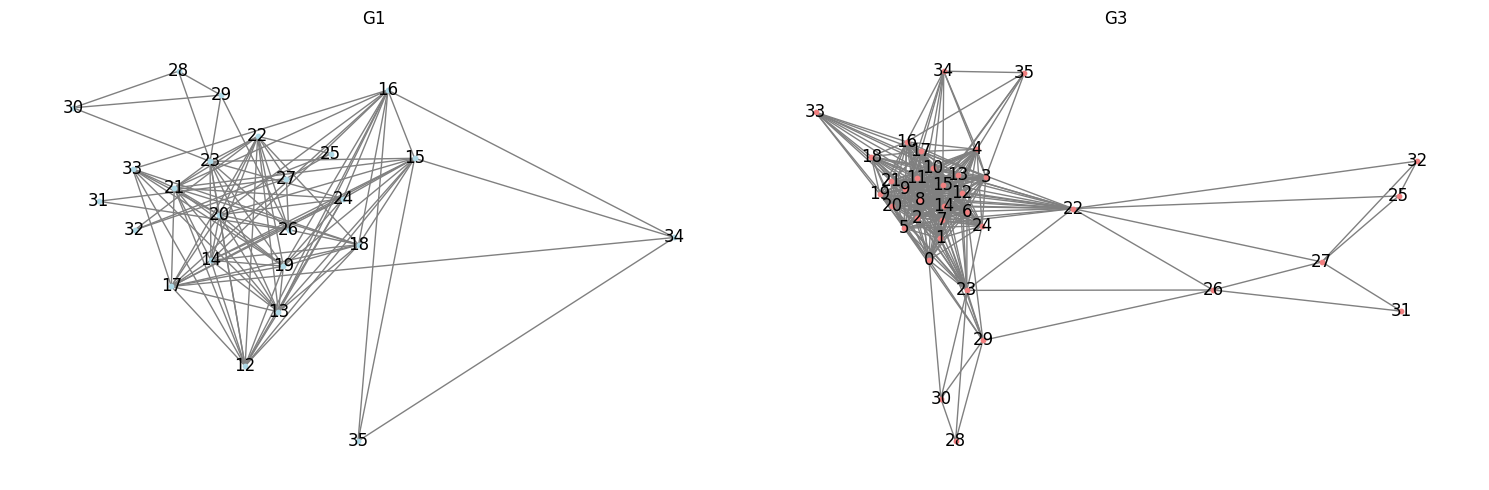

In [37]:
pos = nx.spring_layout(nx_g3, seed=42)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot G1
nx.draw(nx_g1, pos, with_labels=False, ax=axes[0], node_color='lightblue', edge_color='gray', node_size=10)
axes[0].set_title("G1")

node_labels = nx.get_node_attributes(nx_g1, "label")
nx.draw_networkx_labels(nx_g1, pos, labels=node_labels, ax=axes[0], font_size=12, font_color="black")

# # Plot G2
# nx.draw(nx_g2, pos, with_labels=False, ax=axes[1], node_color='lightgreen', edge_color='gray', node_size=10)
# axes[1].set_title("G2")

# node_labels = nx.get_node_attributes(nx_g2, "label")
# nx.draw_networkx_labels(nx_g2, pos, labels=node_labels, ax=axes[1], font_size=12, font_color="black")

# Plot G3
nx.draw(nx_g3, pos, with_labels=False, ax=axes[1], node_color='lightcoral', edge_color='gray', node_size=10)
axes[1].set_title("G3")

node_labels = nx.get_node_attributes(nx_g3, "label")
nx.draw_networkx_labels(nx_g3, pos, labels=node_labels, ax=axes[1], font_size=12, font_color="black")
# Show the figure
plt.tight_layout()
plt.show()

In [38]:
import numpy as np

np.array([109, 168, 90, 171, 147, 53, 108, 95, 24, 125, 132, 42, 85, 107, 25, 58, 114, 37, 54, 111, 27, 184, 142, 60, 63, 79, 143, 7, 28, 78, 2, 13, 145, 52, 75, 139, 31, 129, 183, 137, 47, 116, 115, 177, 83, 0, 36, 123, 61, 1, 49, 156, 135, 164, 69, 140, 199, 10, 122, 56, 73, 141, 23, 113, 67, 176, 118, 134, 65])

array([109, 168,  90, 171, 147,  53, 108,  95,  24, 125, 132,  42,  85,
       107,  25,  58, 114,  37,  54, 111,  27, 184, 142,  60,  63,  79,
       143,   7,  28,  78,   2,  13, 145,  52,  75, 139,  31, 129, 183,
       137,  47, 116, 115, 177,  83,   0,  36, 123,  61,   1,  49, 156,
       135, 164,  69, 140, 199,  10, 122,  56,  73, 141,  23, 113,  67,
       176, 118, 134,  65])

In [39]:
[(n, nbrdict) for n, nbrdict in nx_g3.adjacency()]

[(0,
  {1: {'weight': 0.8685382008552551},
   2: {'weight': 0.5821919441223145},
   3: {'weight': 0.2673640251159668},
   4: {'weight': 0.12036528438329697},
   5: {'weight': 0.7278046011924744},
   6: {'weight': 0.48905497789382935},
   7: {'weight': 0.5284045338630676},
   8: {'weight': 0.32986482977867126},
   9: {'weight': 0.27389782667160034},
   10: {'weight': 0.2612859606742859},
   11: {'weight': 0.28646036982536316},
   12: {'weight': 0.34785735607147217},
   13: {'weight': 0.2522658705711365},
   14: {'weight': 0.46141955256462097},
   15: {'weight': 0.36405202746391296},
   19: {'weight': 0.2775423228740692},
   20: {'weight': 0.32009631395339966},
   21: {'weight': 0.28860101103782654},
   23: {'weight': 0.7337775230407715},
   24: {'weight': 0.6333024501800537},
   29: {'weight': 0.4838450253009796},
   30: {'weight': 0.19090227782726288}}),
 (1,
  {0: {'weight': 0.8685382008552551},
   2: {'weight': 0.8660440444946289},
   3: {'weight': 0.5318829417228699},
   4: {'weight

In [42]:
import os

def load_model_and_infer(og_path: str):
    torch.set_float32_matmul_precision('high')
    
    result = []
    for root, dirs, files in os.walk(og_path):
        for name in files:
            if 'ckpt' in name:
                result.append(os.path.join(root, name))
    
    assert len(result)
    checkpoint_path = result[0]
    
    # Load configuration
    cfg = OmegaConf.load(os.path.join(og_path, 'config.yaml'))
    
    # Load dataset
    dataset = get_dataset(cfg.dataset.name,
                        p_fault=cfg.dataset.get('p_fault'),
                        p_noise=cfg.dataset.get('p_noise'),
                        t_range=cfg.dataset.get('t_range'),
                        masked_s=cfg.dataset.get('masked_sensors'),
                        agg_func=cfg.dataset.get('agg_func'),
                        test_month=cfg.dataset.get('test_month'),
                        location=cfg.dataset.get('location'))
    # covariates = {'u': dataset.datetime_encoded('day').values}

    if cfg.model.name == 'kits' or cfg.model.name == 'unkrig':
        adj = dataset.get_connectivity(**cfg.dataset.connectivity, layout='dense')
    else:
        adj = dataset.get_connectivity(**cfg.dataset.connectivity)
    
    torch_dataset = ImputationDataset(
        target=dataset.dataframe(),
        mask=dataset.training_mask,
        eval_mask=dataset.eval_mask,
        # covariates=covariates,
        transform=MaskInput(),
        connectivity=adj,
        window=cfg.window,
        stride=cfg.stride
    )
    
    scalers = {'target': StandardScaler(axis=(0, 1))}

    dm = SpatioTemporalDataModule(
        dataset=torch_dataset,
        scalers=scalers,
        splitter=dataset.get_splitter(**cfg.dataset.splitting),
        batch_size=cfg.batch_size,
        workers=cfg.workers)
    
    dm.setup(stage='test')
    
    # Load model
    model_cls = get_model_class(cfg.model.name)
    
    if cfg.model.name == 'kits':
        model_kwargs = dict(adj=adj, d_in=dm.n_channels, n_nodes=dm.n_nodes, args=cfg.model)
    elif cfg.model.name == 'unkrig':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels)
    else:
        model_kwargs = dict(n_nodes=torch_dataset.n_nodes,
                            input_size=torch_dataset.n_channels)
        
    model_cls.filter_model_args_(model_kwargs)
    model_kwargs.update(cfg.model.hparams)

    trainer = Trainer(
        max_epochs=cfg.epochs,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=cfg.device,
        gradient_clip_val=cfg.grad_clip_val,
        gradient_clip_algorithm=cfg.grad_clip_alg,)
    
    print(model_cls)
    
    if cfg.model.name == 'kits':
        imputer = GCNCycVirtualFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls, model_kwargs=model_kwargs,
                                                            gradient_clip_val=cfg.grad_clip_val,
                                                            gradient_clip_algorithm=cfg.grad_clip_alg,
                                                            **cfg.model.technique)
    elif cfg.model.name == "unkrig":
        imputer = UnnamedKrigFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                                    model_kwargs=model_kwargs,
                                    gradient_clip_val=cfg.grad_clip_val,
                                    gradient_clip_algorithm=cfg.grad_clip_alg,
                                    **cfg.model.regs)
    else:
        imputer = Imputer.load_from_checkpoint(checkpoint_path, model_class=model_cls, model_kwargs=model_kwargs)

    imputer.eval()

    # trainer.test(imputer, datamodule=dm)
    
    # # Run inference
    # trainer = torch.utils.data.DataLoader(dm.test_dataloader(), batch_size=cfg.batch_size)
    output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
    output = imputer.collate_prediction_outputs(output)
    output = torch_to_numpy(output)
    
    y_hat, y_true, mask, invars, vars, inv_adj, var_adj = (output['y_hat'], output['y'],
                                                        output.get('eval_mask', None),
                                                        output.get('invars', None),
                                                        output.get('vars', None),
                                                        output.get('inv_adj', None),
                                                        output.get('var_adj', None))
    # mask[:, :, 12, :] = 0
    # mask[:, :, 4, :] = True
    res = dict(test_mae=numpy_metrics.mae(y_hat, y_true, mask),
               test_mre=numpy_metrics.mre(y_hat, y_true, mask),
               test_mape=numpy_metrics.mape(y_hat, y_true, mask),
               test_rmse=numpy_metrics.rmse(y_hat, y_true, mask))
    
    return y_hat, y_true, mask, res, dm, dataset, model_cls, invars, vars, inv_adj, var_adj


In [41]:
# checkpoint_path = '../logs/grin/air_auckland/2025-02-14/19-54-32'  # Path to model checkpoint
# checkpoint_path = '../logs/kits/air_auckland/2025-02-19/09-48-59'
# checkpoint_path = '../logs/grin/air_smaller/2025-02-14/14-55-20'
# checkpoint_path = '../logs/kits/air_smaller/2025-02-19/09-54-29'
# checkpoint_path = '../logs/kits/air_smaller/2025-02-19/10-55-18'
# checkpoint_path = '../logs/grin/air_smaller/2025-02-19/10-58-42'
# checkpoint_path = '../logs/grin/air_auckland/2025-02-19/15-37-49'
# checkpoint_path = '../logs/kits/air_auckland/2025-02-19/15-37-26'
# checkpoint_path = '../logs/grin/air_auckland/2025-02-20/22-32-34'     # 12
# checkpoint_path = '../logs/kits/air_auckland/2025-02-20/22-33-02'     # 12
# checkpoint_path = '../logs/birnni/air_auckland/2025-02-22/12-11-55'   # 12

# checkpoint_path = '../logs/grin/air_smaller/2025-02-21/10-00-18'      # 24
# checkpoint_path = '../logs/kits/air_smaller/2025-02-21/10-00-58'      # 24

# checkpoint_path = '../logs/grin/air_smaller/2025-02-21/10-04-01'      # 12
# checkpoint_path = '../logs/kits/air_smaller/2025-02-21/10-03-48'      # 12
# checkpoint_path = '../logs/birnni/air_smaller/2025-02-22/21-38-26'    # 12

## FINAL AUCKLAND RES
# Henderson
# checkpoint_path = '../logs/grin/air_auckland/2025-02-22/23-45-18'       # 24
# checkpoint_path = '../logs/kits/air_auckland/2025-02-22/23-42-45'     # 24
# checkpoint_path = '../logs/birnni/air_auckland/2025-02-22/22-59-41'

# Henderson month 6
# checkpoint_path = '../logs/grin/air_auckland/2025-02-23/00-37-22'
# checkpoint_path = '../logs/kits/air_auckland/2025-02-23/00-31-41'
# checkpoint_path = '../logs/birnni/air_auckland/2025-02-23/00-32-09'

# Mt Albert month 6
# checkpoint_path = '../logs/grin/air_auckland/2025-02-23/17-15-22'
# checkpoint_path = '../logs/kits/air_auckland/2025-02-23/17-15-37'
# checkpoint_path = '../logs/birnni/air_auckland/2025-02-23/17-15-57'

# Beijing Dataset
# checkpoint_path = '../logs/kits/air/2025-02-23/18-56-03'
# checkpoint_path = '../logs/grin/air/2025-02-23/18-57-03'
checkpoint_path = '../logs/kits/air/2025-03-24/transfer'

checkpoint_path = '../logs/grin/air/2025-03-25/17-07-23'
# checkpoint_path = '../logs/kits/air/2025-03-26/12-04-32'

checkpoint_path = '../logs/unkrig/air/2025-04-09/15-08-32'
y_hat, y_true, mask, res, dm, dataset, model = load_model_and_infer(checkpoint_path)
res

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<class 'unnamedKrig.UnnamedKrigModel'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]


Predicting DataLoader 0:   0%|          | 0/23 [00:00<?, ?it/s]huh torch.Size([3072, 36, 128])
when torch.Size([3072, 36, 128])
Predicting DataLoader 0:   4%|▍         | 1/23 [00:00<00:13,  1.68it/s]huh torch.Size([3072, 36, 128])
when torch.Size([3072, 36, 128])
Predicting DataLoader 0:   9%|▊         | 2/23 [00:00<00:09,  2.16it/s]huh torch.Size([3072, 36, 128])
when torch.Size([3072, 36, 128])
Predicting DataLoader 0:  13%|█▎        | 3/23 [00:01<00:08,  2.42it/s]huh torch.Size([3072, 36, 128])
when torch.Size([3072, 36, 128])
Predicting DataLoader 0:  17%|█▋        | 4/23 [00:01<00:07,  2.61it/s]huh torch.Size([3072, 36, 128])
when torch.Size([3072, 36, 128])
Predicting DataLoader 0:  22%|██▏       | 5/23 [00:01<00:06,  2.73it/s]huh torch.Size([3072, 36, 128])
when torch.Size([3072, 36, 128])
Predicting DataLoader 0:  26%|██▌       | 6/23 [00:02<00:06,  2.82it/s]huh torch.Size([3072, 36, 128])
when torch.Size([3072, 36, 128])
Predicting DataLoader 0:  30%|███       | 7/23 [00:02<00

ValueError: too many values to unpack (expected 7)

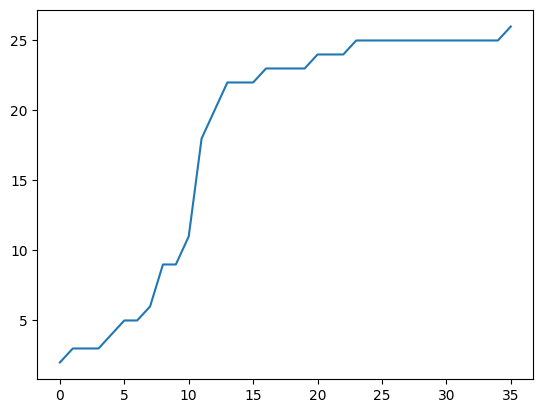

In [ ]:
inds = np.argsort([d for n, d in nx_g3.degree()])

plt.plot(sorted(nx_g3.degree()[d] for d in inds))

In [ ]:
nx.degree_centrality(nx_g3).values()

dict_values([0.6285714285714286, 0.6571428571428571, 0.6571428571428571, 0.6571428571428571, 0.6571428571428571, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7428571428571429, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.6857142857142857, 0.7142857142857143, 0.6857142857142857, 0.6857142857142857, 0.5142857142857142, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.5714285714285714, 0.6285714285714286, 0.6285714285714286, 0.08571428571428572, 0.14285714285714285, 0.14285714285714285, 0.08571428571428572, 0.2571428571428571, 0.11428571428571428, 0.05714285714285714, 0.08571428571428572, 0.3142857142857143, 0.2571428571428571, 0.17142857142857143])

In [ ]:
np.array(list(nx.closeness_centrality(nx_g3).values()))[inv_c_in]

NameError: name 'inv_c_in' is not defined

In [ ]:
np.array(list(nx.closeness_centrality(nx_g3).values()))[inv_c_in]
np.array(list(nx.closeness_centrality(nx_g3).values()))[c_in]

NameError: name 'inv_c_in' is not defined

In [ ]:
e_in

[117,
 174,
 170,
 165,
 133,
 124,
 72,
 205,
 64,
 29,
 40,
 70,
 190,
 101,
 30,
 71,
 102,
 74,
 119,
 103,
 48,
 196,
 175,
 166,
 98,
 57,
 68,
 6,
 138,
 22,
 39,
 38,
 93,
 16,
 20,
 91,
 19,
 136,
 144,
 94,
 33,
 32,
 15,
 5,
 96,
 3,
 4,
 191,
 206,
 192,
 127,
 97,
 17,
 193,
 128,
 198,
 157,
 159,
 80,
 155,
 162,
 161,
 163,
 195,
 187,
 12,
 188,
 154,
 160]

In [ ]:
e_ind

array([ 26, 126, 200,  21, 121,  18, 189,  50,  35, 182, 181, 180, 186,
        59, 150,   8,  34, 185,  46,  66, 203, 149,  87, 100,  14,  86,
       104, 112,  89, 151, 148, 172,  88, 202,   9,  51,  84, 204, 130,
        41, 197,  77, 194,  43,  45,  44,  92, 153, 152, 146, 105, 120,
        99, 158, 179, 131, 201, 167, 106,  82,  76,  11, 110, 178,  55,
       173,  81,  62, 169, 109, 168,  90, 171, 147,  53, 108,  95,  24,
       125, 132,  42,  85, 107,  25,  58, 114,  37,  54, 111,  27, 184,
       142,  60,  63,  79, 143,   7,  28,  78,   2,  13, 145,  52,  75,
       139,  31, 129, 183, 137,  47, 116, 115, 177,  83,   0,  36, 123,
        61,   1,  49, 156, 135, 164,  69, 140, 199,  10, 122,  56,  73,
       141,  23, 113,  67, 176, 118, 134,  65, 117, 174, 170, 165, 133,
       124,  72, 205,  64,  29,  40,  70, 190, 101,  30,  71, 102,  74,
       119, 103,  48, 196, 175, 166,  98,  57,  68,   6, 138,  22,  39,
        38,  93,  16,  20,  91,  19, 136, 144,  94,  33,  32,  1

In [ ]:
e_in, inv_e_in

([117,
  174,
  170,
  165,
  133,
  124,
  72,
  205,
  64,
  29,
  40,
  70,
  190,
  101,
  30,
  71,
  102,
  74,
  119,
  103,
  48,
  196,
  175,
  166,
  98,
  57,
  68,
  6,
  138,
  22,
  39,
  38,
  93,
  16,
  20,
  91,
  19,
  136,
  144,
  94,
  33,
  32,
  15,
  5,
  96,
  3,
  4,
  191,
  206,
  192,
  127,
  97,
  17,
  193,
  128,
  198,
  157,
  159,
  80,
  155,
  162,
  161,
  163,
  195,
  187,
  12,
  188,
  154,
  160],
 [26,
  126,
  200,
  21,
  121,
  18,
  189,
  50,
  35,
  182,
  181,
  180,
  186,
  59,
  150,
  8,
  34,
  185,
  46,
  66,
  203,
  149,
  87,
  100,
  14,
  86,
  104,
  112,
  89,
  151,
  148,
  172,
  88,
  202,
  9,
  51,
  84,
  204,
  130,
  41,
  197,
  77,
  194,
  43,
  45,
  44,
  92,
  153,
  152,
  146,
  105,
  120,
  99,
  158,
  179,
  131,
  201,
  167,
  106,
  82,
  76,
  11,
  110,
  178,
  55,
  173,
  81,
  62,
  169,
  109,
  168,
  90,
  171,
  147,
  53,
  108,
  95,
  24,
  125,
  132,
  42,
  85,
  107,
  25,
  58,

0.1461693995472803
nan
0.6402703022036605
nan


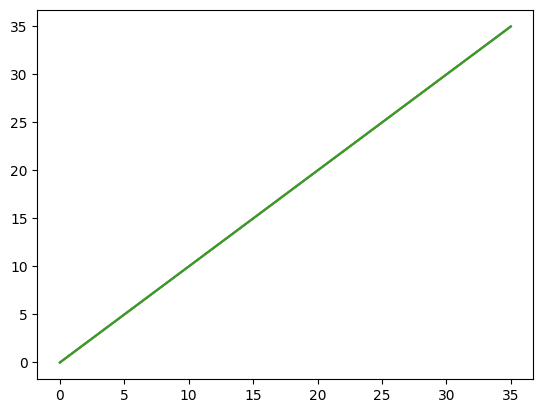

nan
0.1461693995472803
nan
0.6402703022036605


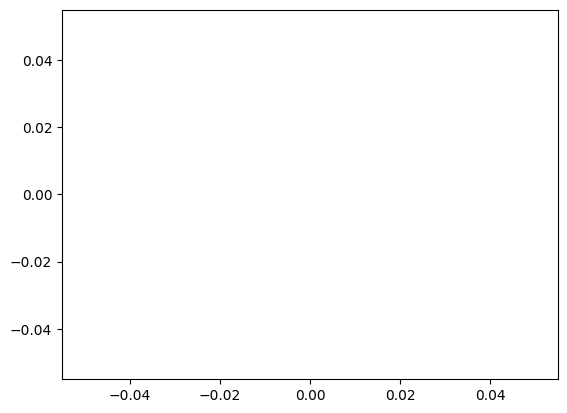

nan
0.1461693995472803
nan
0.6402703022036605


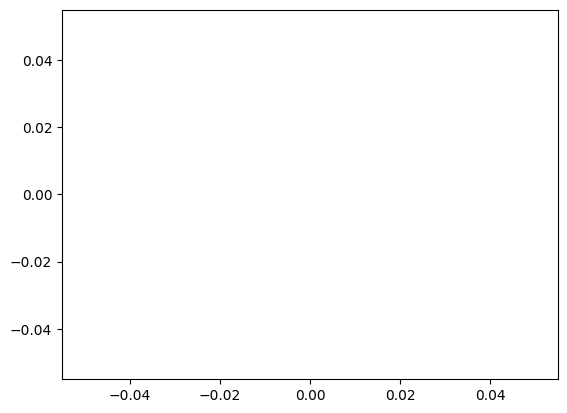

In [ ]:
e_ind = np.argsort(list(nx.eigenvector_centrality(nx_g3).values()))
c_ind = np.argsort(list(nx.closeness_centrality(nx_g3).values()))
d_ind = np.argsort([d for n, d in nx_g3.degree()])
t_ind = np.argsort(list(nx.degree_centrality(nx_g3).values()))

for inds in range(3):
    e_in = (e_ind[inds*69:(inds+1)*69]).tolist()
    c_in = (c_ind[inds*69:(inds+1)*69]).tolist()

    inv_e_in = (np.delete(e_ind, np.argwhere(np.isin(e_ind, e_in)))).tolist()
    inv_c_in = (np.delete(c_ind, np.argwhere(np.isin(c_ind, c_in)))).tolist()

    print(np.mean(np.array(list(nx.eigenvector_centrality(nx_g3).values()))[e_in]))
    print(np.mean(np.array(list(nx.eigenvector_centrality(nx_g3).values()))[inv_e_in]))

    print(np.mean(np.array(list(nx.closeness_centrality(nx_g3).values()))[c_in]))
    print(np.mean(np.array(list(nx.closeness_centrality(nx_g3).values()))[inv_c_in]))

    plt.plot(np.sort(e_ind[inds*69:(inds+1)*69]))
    plt.plot(np.sort(c_ind[inds*69:(inds+1)*69]))
    plt.plot(np.sort(d_ind[inds*69:(inds+1)*69]))
    plt.show()

In [ ]:
np.argsort([d for n, d in nx_g3.degree()]).shape

(207,)

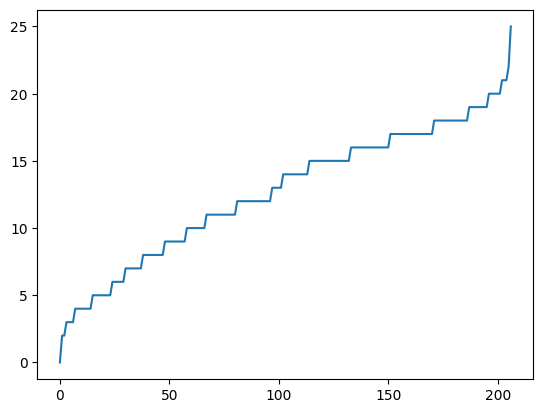

In [ ]:
plt.plot(sorted([d for n, d in nx_g3.degree()]))

In [ ]:
torch.where(torch.sum(dm.eval_mask, dim=0) > 0)

NameError: name 'dm' is not defined

In [ ]:
checkpoint = torch.load('../logs/kits/air_invercargill1/transfer/epoch=115-step=18212.ckpt')


In [ ]:
# checkpoint['hyper_parameters']
mape_mat

matrix = np.where(np.isinf(mape_mat), np.nan, mape_mat)  # Replace inf with NaN
cov_mean = np.nanmean(matrix, axis=0)
np.argsort(cov_mean)

array([107, 171, 173, 121,  66,  21,  92,  45,   7,  50,  11, 202, 184,
       178, 153,  44,  46, 189,   1,  35, 132, 108, 169, 200, 152, 203,
       201, 110,  90,  27, 177, 182,  31,  55, 168, 183,  85, 123,  99,
       135, 167,  24,  36,  67, 126, 114,  59, 118,  18, 147,  58,  13,
       116,   2,  37, 143,  49,   8, 129, 186,  71, 181,  86,  28, 115,
       185,  34,  54,  94,  10, 205,  19, 180, 109,  39, 120,  78, 117,
        20,  74,  32,   0, 128, 175,  40,  69,  89,  70,  68,  79, 145,
        83, 111, 161, 194, 179,  80,  87, 188,  97, 119, 103,  52,  41,
        57,  42, 190, 156, 162, 157, 204, 195, 137,  63, 158,  17, 198,
       131, 136, 112,  47,  72,  62,  60, 141,  98, 164, 192, 172,  96,
       104, 154, 101,  33, 113, 133,  30, 142,  25,   6, 148,   3,  65,
       102, 130, 122, 138,  53,  93, 100, 170, 150,  76,   5, 134, 146,
        51, 151, 166,  75,  81,  15,  95, 140,  73,   4, 176,  64, 124,
        43,  14, 191, 174,  22,  88, 199, 139, 193,  84,  48,  8

In [ ]:
features_raw = torch.tensor(dataset.dataframe().values).T
# features_raw = features_raw[:, 1:] - features_raw[:, :-1]
partition = 0
parts = inds[partition*69:(partition+1)*69]
parts = np.arange(207)
print(parts)
parts_adj = adj[:, parts]
parts_adj = parts_adj[parts, :]

# COV
cov_mat = np.cov(features_raw.T, rowvar=False, bias=False)
std_devs = np.sqrt(np.diag(cov_mat))
std_dev_outer = np.outer(std_devs, std_devs)
mape_mat = np.divide(cov_mat, std_dev_outer, where=std_dev_outer != 0)
mape_mat = mape_mat[:, parts]
mape_mat = mape_mat[parts, :]
mape_mat = np.where(parts_adj > 0, mape_mat, np.ones_like(mape_mat)*(-np.inf))


# MAPE
# mape_mat = np.zeros((parts.shape[0], parts.shape[0]))
# for i in range(parts.shape[0]):
#     for j in range(parts.shape[0]):
#         mape_mat[i, j] = numpy_metrics.mape(features_raw[parts[i]], features_raw[parts[j]])

# mape_mat = np.where(parts_adj > 0, mape_mat, np.ones_like(mape_mat)*(-np.inf))


# Filters lowest correlated nodes
matrix = np.where(np.isinf(mape_mat), np.nan, mape_mat)  # Replace inf with NaN
cov_mean = np.nanmean(matrix, axis=0)
part_mean = np.argsort(cov_mean)[2*69:]

mape_mat = mape_mat[:, part_mean]
mape_mat = mape_mat[part_mean, :]

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(mape_mat, cmap="coolwarm", interpolation="nearest", vmax=1)
plt.colorbar(label="Correlation")

# # Add text annotations
# for i in range(mape_mat.shape[0]):
#     for j in range(mape_mat.shape[1]):
#         plt.text(j, i, f"{mape_mat[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("MAPE Matrix")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(mape_mat.shape[0]))
plt.yticks(range(mape_mat.shape[1]))
plt.show()

NameError: name 'inds' is not defined

In [ ]:
mape_mat

partition = 0

matrix = np.where(np.isinf(mape_mat), np.nan, mape_mat)  # Replace inf with NaN
cov_mean = np.nanmean(matrix, axis=0)
np.argsort(cov_mean)[partition*69:(partition+1)*69]

array([149,  10, 156,  90, 183,  64,  66,  55,  31, 118, 107,  99,  46,
        27, 105, 179,   7,  65,  92,  11,  30, 171, 109, 184, 152, 177,
       123, 135,   1,  53, 170,  89, 112, 173, 108,  28,  78, 132, 110,
       153,  29,  44,  71,  62, 106,  67,  49, 129,  48,  85, 125, 122,
       202, 167,  79, 178, 104, 196, 139, 194,   2, 166, 201,  58,  45,
       114,  51,  96, 147])

In [43]:
# paths = ['../logs/kits/air_invercargill1/2025-02-26/14-27-48', '../logs/grin/air_invercargill1/2025-02-26/14-33-13']
# paths = ['../logs/grin/air/2025-03-25/16-54-45', '../logs/kits/air/2025-03-26/14-35-18']
# paths = ['../logs/grin/air/2025-03-25/16-56-35', '../logs/kits/air/2025-03-26/14-36-41']
# paths = ['../logs/grin/air/2025-03-25/17-07-23', '../logs/kits/air/2025-03-26/15-02-39']
# paths = ['../logs/kits/air/2025-03-27/23-19-56', '../logs/kits/air/2025-03-27/23-20-47', '../logs/kits/air/2025-03-27/23-21-11', 
#          '../logs/kits/air/2025-03-27/23-33-33', '../logs/kits/air/2025-03-27/23-34-20']
# paths = ['../logs/kits/air/2025-03-28/10-08-58', '../logs/kits/air/2025-03-28/10-15-16', '../logs/kits/air/2025-03-28/10-36-17']
# paths = ['../logs/kits/air/2025-03-28/16-16-09', '../logs/kits/air/2025-03-28/16-16-44']
# paths = ['../logs/kits/metrla/2025-03-31/11-58-42', '../logs/kits/metrla/2025-03-31/11-59-30',
#          '../logs/kits/metrla/2025-03-31/14-41-54', '../logs/kits/metrla/2025-03-31/transfer_test']

# paths = ['../logs/kits/metrla/2025-04-03/transfer1']
paths = ['../logs/unkrig/air/2025-04-09/15-08-32']

deets = []
for path in paths:
    res = load_model_and_infer(path)
    deets.append(res)
    print(res[3])

# deets[3] = load_model_and_infer(paths[3])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<class 'unnamedKrig.UnnamedKrigModel'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]


Predicting DataLoader 0:   0%|          | 0/23 [00:00<?, ?it/s]huh torch.Size([3072, 36, 128])
when torch.Size([3072, 36, 128])
Predicting DataLoader 0:   4%|▍         | 1/23 [00:00<00:04,  4.69it/s]huh torch.Size([3072, 36, 128])
when torch.Size([3072, 36, 128])
Predicting DataLoader 0:   9%|▊         | 2/23 [00:00<00:05,  3.84it/s]huh torch.Size([3072, 36, 128])
when torch.Size([3072, 36, 128])
Predicting DataLoader 0:  13%|█▎        | 3/23 [00:00<00:05,  3.65it/s]huh torch.Size([3072, 36, 128])
when torch.Size([3072, 36, 128])
Predicting DataLoader 0:  17%|█▋        | 4/23 [00:01<00:05,  3.56it/s]huh torch.Size([3072, 36, 128])
when torch.Size([3072, 36, 128])
Predicting DataLoader 0:  22%|██▏       | 5/23 [00:01<00:05,  3.51it/s]huh torch.Size([3072, 36, 128])
when torch.Size([3072, 36, 128])
Predicting DataLoader 0:  26%|██▌       | 6/23 [00:01<00:04,  3.49it/s]huh torch.Size([3072, 36, 128])
when torch.Size([3072, 36, 128])
Predicting DataLoader 0:  30%|███       | 7/23 [00:02<00

In [ ]:
deets[0][0][:, 0, 26, 0]

array([58.916603, 58.916603, 58.916603, ..., 58.916603, 58.916603,
       58.916603], dtype=float32)

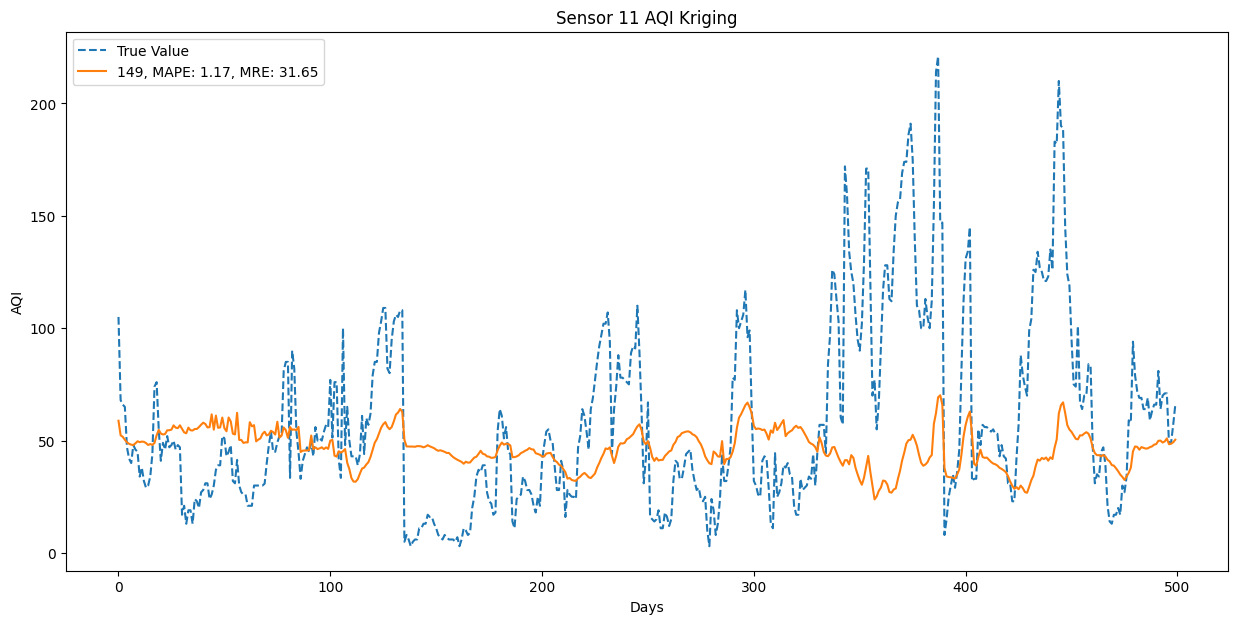

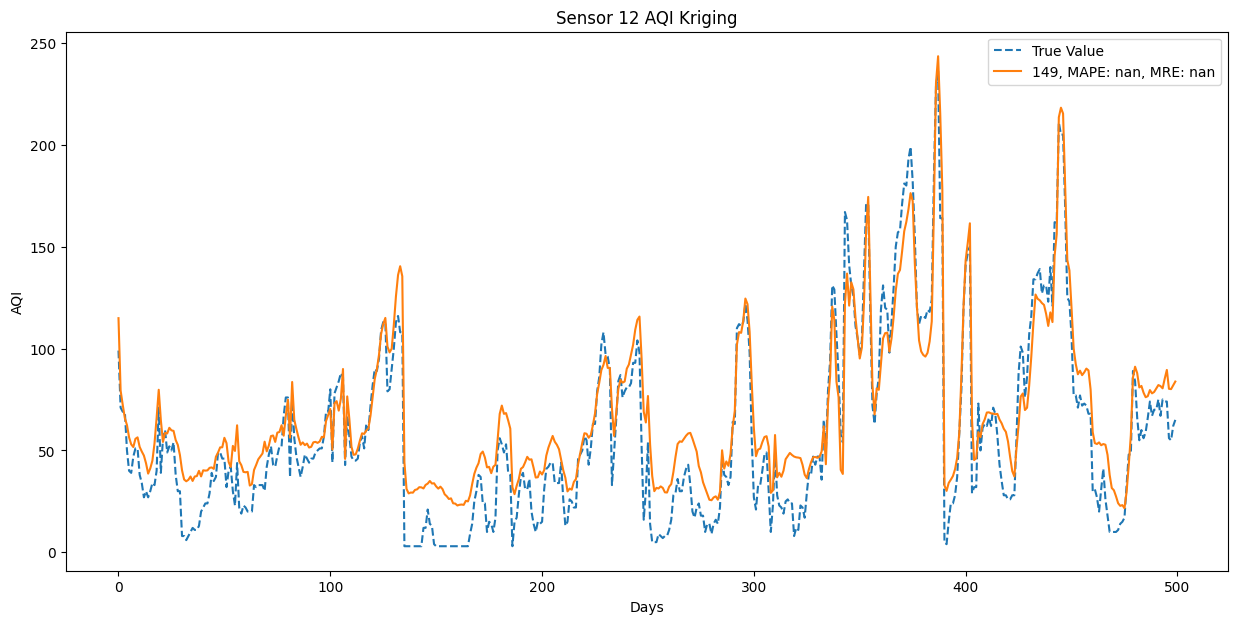

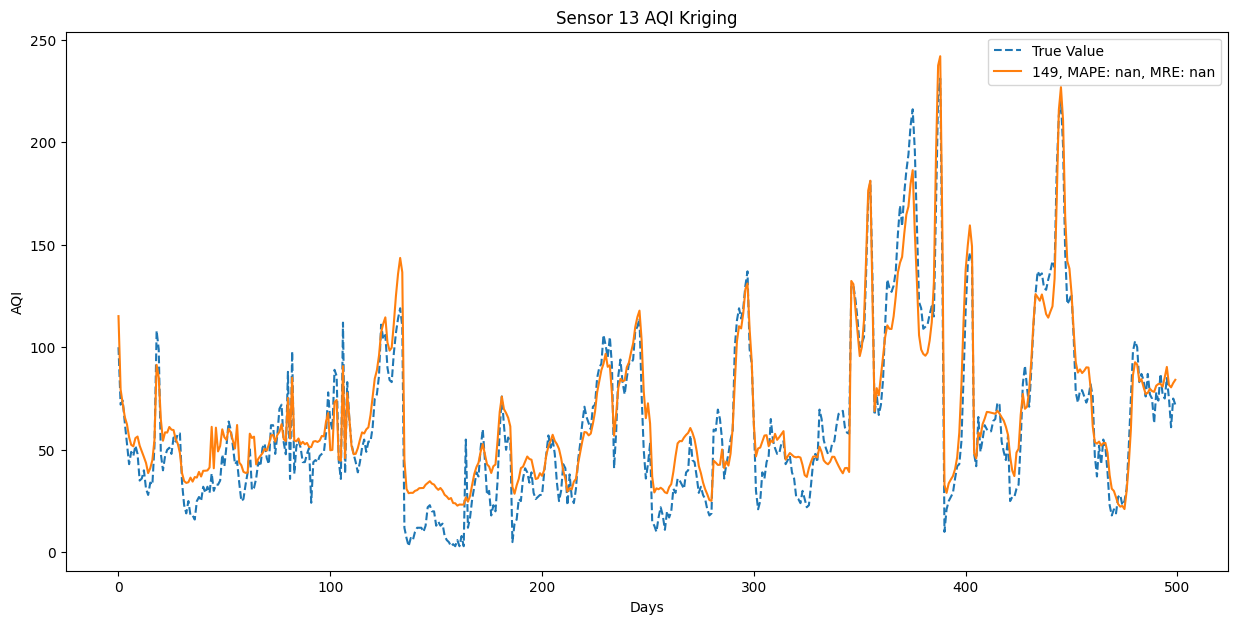

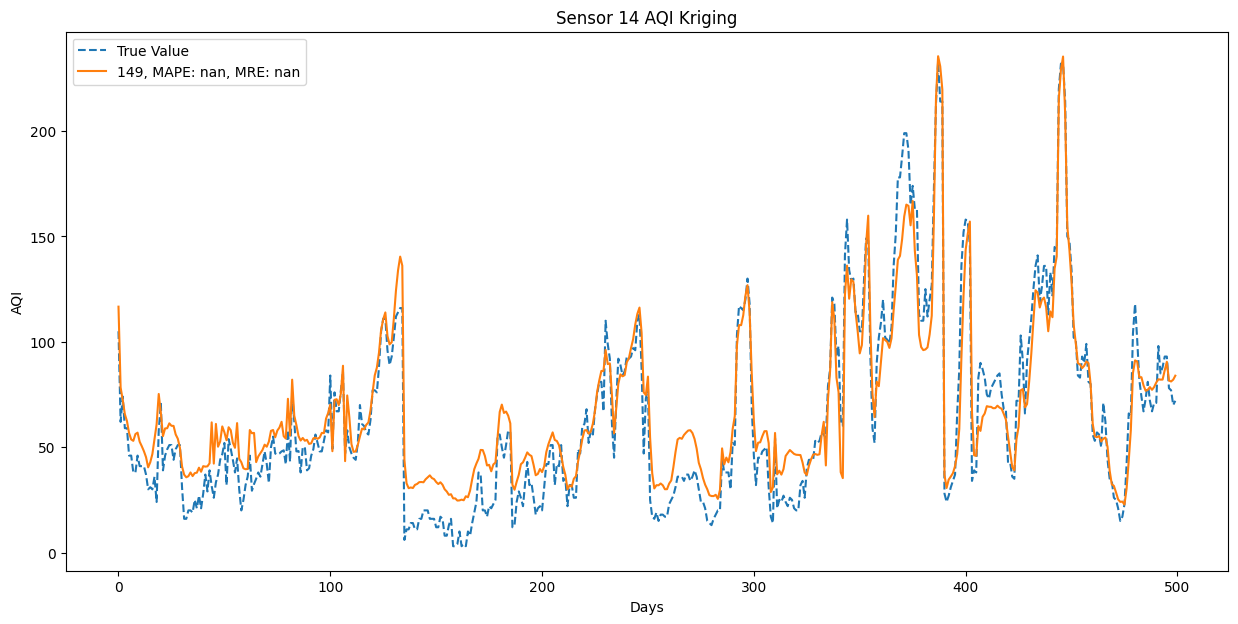

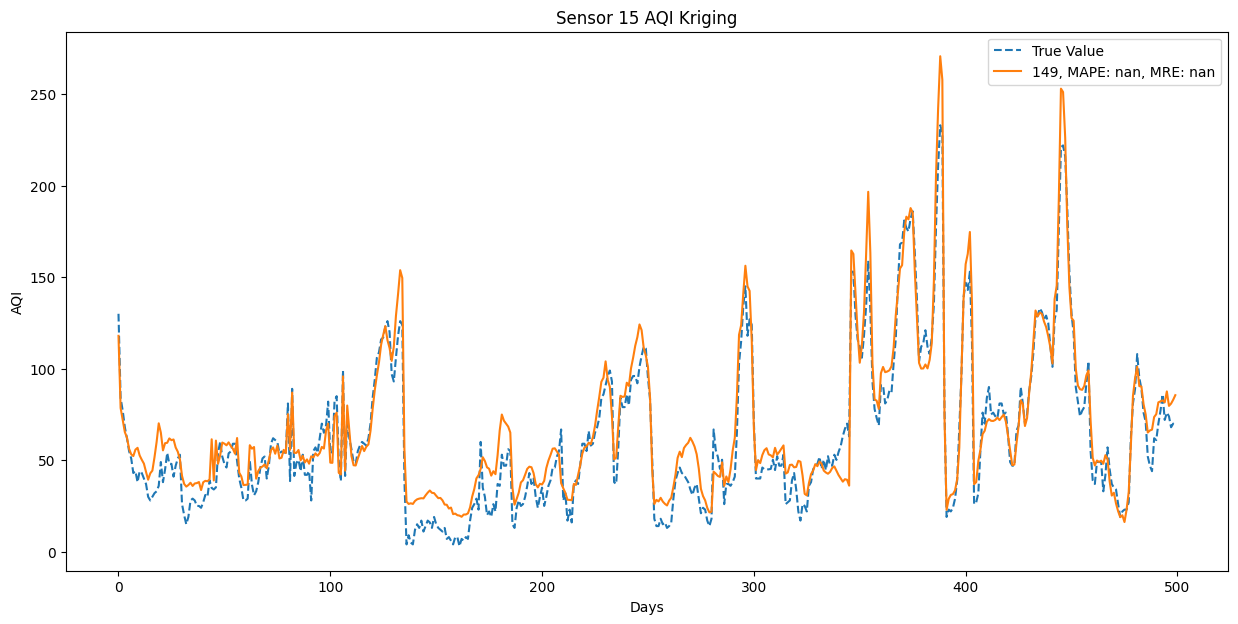

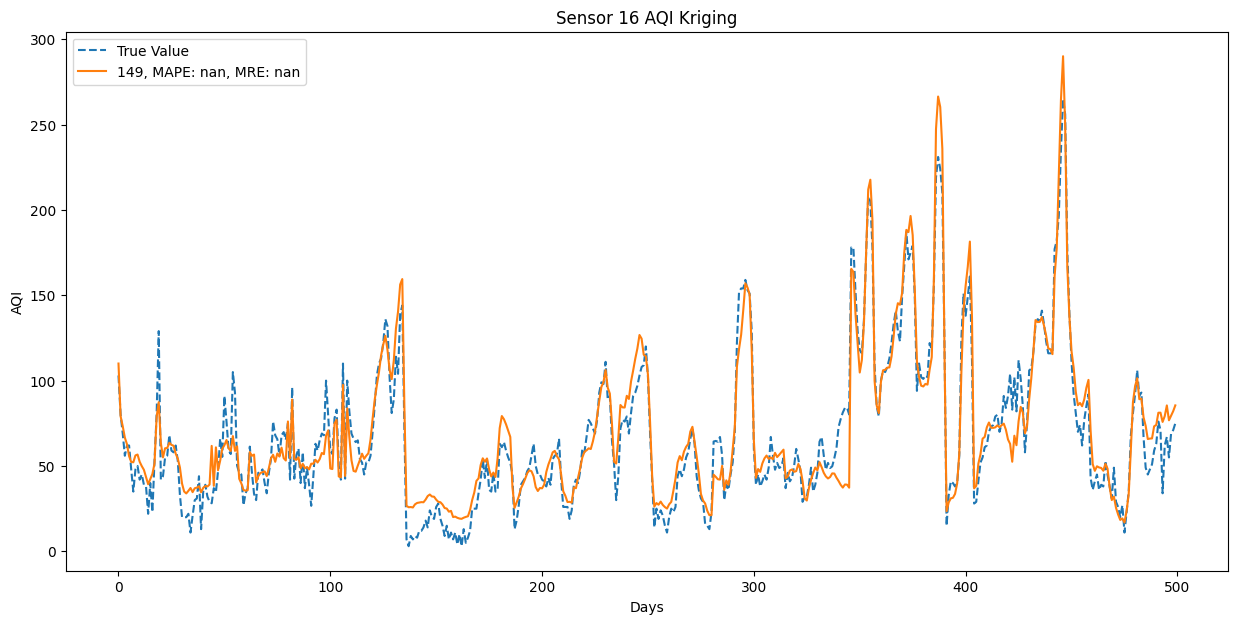

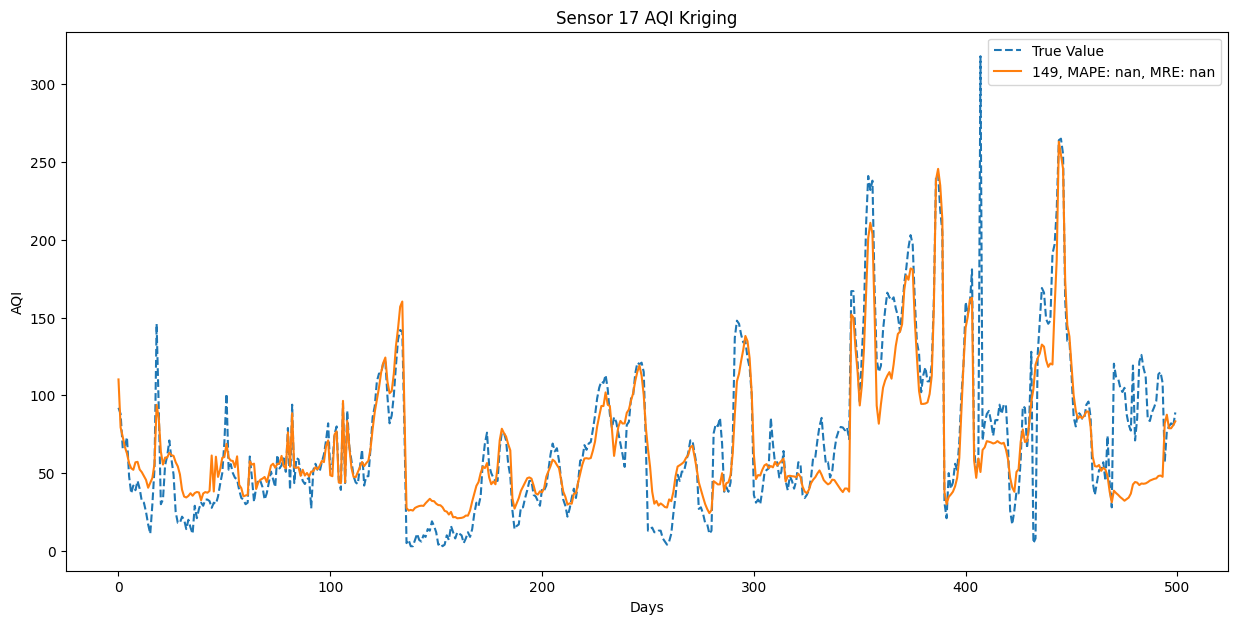

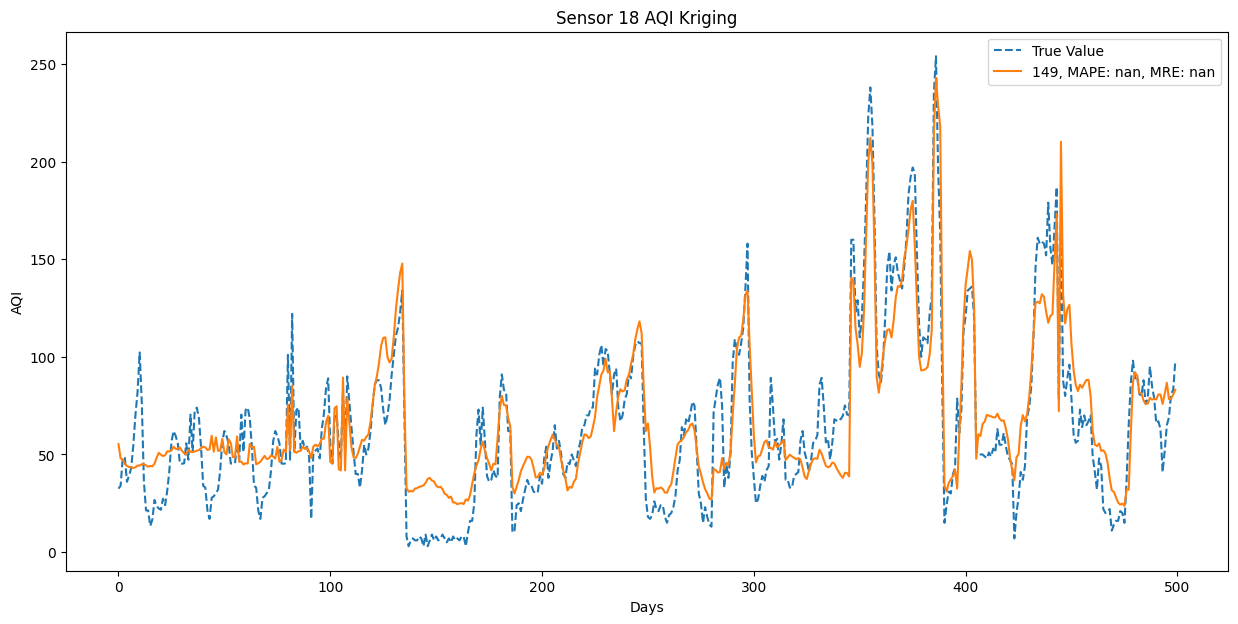

In [44]:
titles = ['149', '26', '40', '172']
styles = ['-']
ranges = [0, 500]

sensors = [166, 16, 196, 12, 193, 187, 195]
sensors = [11, 12, 13, 14, 15, 16, 17, 18]
# sensors = range(37)

# deets = [[y_hat, y_true, mask, res, dm, dataset]]

for sensor in sensors:
    plt.figure(figsize=(15,7))
    y_true = deets[0][1]

    # y_true = np.where(deets[0][2] == 1, y_true, 400)

    plt.plot(y_true[ranges[0]:ranges[1], 0, sensor, :], '--', label='True Value')
    # plt.plot(deets[1][0][ranges[0]:ranges[1], 0, 33, :], '--', label='KITS')
    for ind, deet in enumerate(deets):
        y_hat = deet[0]
        test_mape=numpy_metrics.mape(y_hat[ranges[0]:ranges[1], :, sensor, :], 
                                    y_true[ranges[0]:ranges[1], :, sensor, :], 
                                    deet[2][ranges[0]:ranges[1], :, sensor, :])
        test_mre=numpy_metrics.mae(y_hat[ranges[0]:ranges[1], :, sensor, :], 
                                    y_true[ranges[0]:ranges[1], :, sensor, :], 
                                    deet[2][ranges[0]:ranges[1], :, sensor, :])

    # if test_mre > 20:
    plt.plot(y_hat[ranges[0]:ranges[1], 0, sensor, :], label=f'{titles[ind]}, MAPE: {test_mape:.2f}, MRE: {test_mre:.2f}')
        # plt.plot(deet[1][ranges[0]:ranges[1], 0, 4, :], label=f'True Value')

    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.legend()
    plt.title(f'Sensor {sensor} AQI Kriging')
    plt.show()

In [ ]:
deets[1][1], deets[1][0]

In [ ]:
(deets[0][5].dataframe().values.T).shape

In [ ]:
adj

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.7174379, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.7174379, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
nx.google_matrix(nx_g3)

array([[0.00072464, 0.00072464, 0.00072464, ..., 0.00072464, 0.00072464,
        0.00072464],
       [0.00072464, 0.00072464, 0.09043099, ..., 0.00072464, 0.00072464,
        0.00072464],
       [0.00072464, 0.09994487, 0.00072464, ..., 0.00072464, 0.00072464,
        0.00072464],
       ...,
       [0.00072464, 0.00072464, 0.00072464, ..., 0.00072464, 0.00072464,
        0.00072464],
       [0.00072464, 0.00072464, 0.00072464, ..., 0.00072464, 0.00072464,
        0.00072464],
       [0.00072464, 0.00072464, 0.00072464, ..., 0.00072464, 0.00072464,
        0.00072464]])

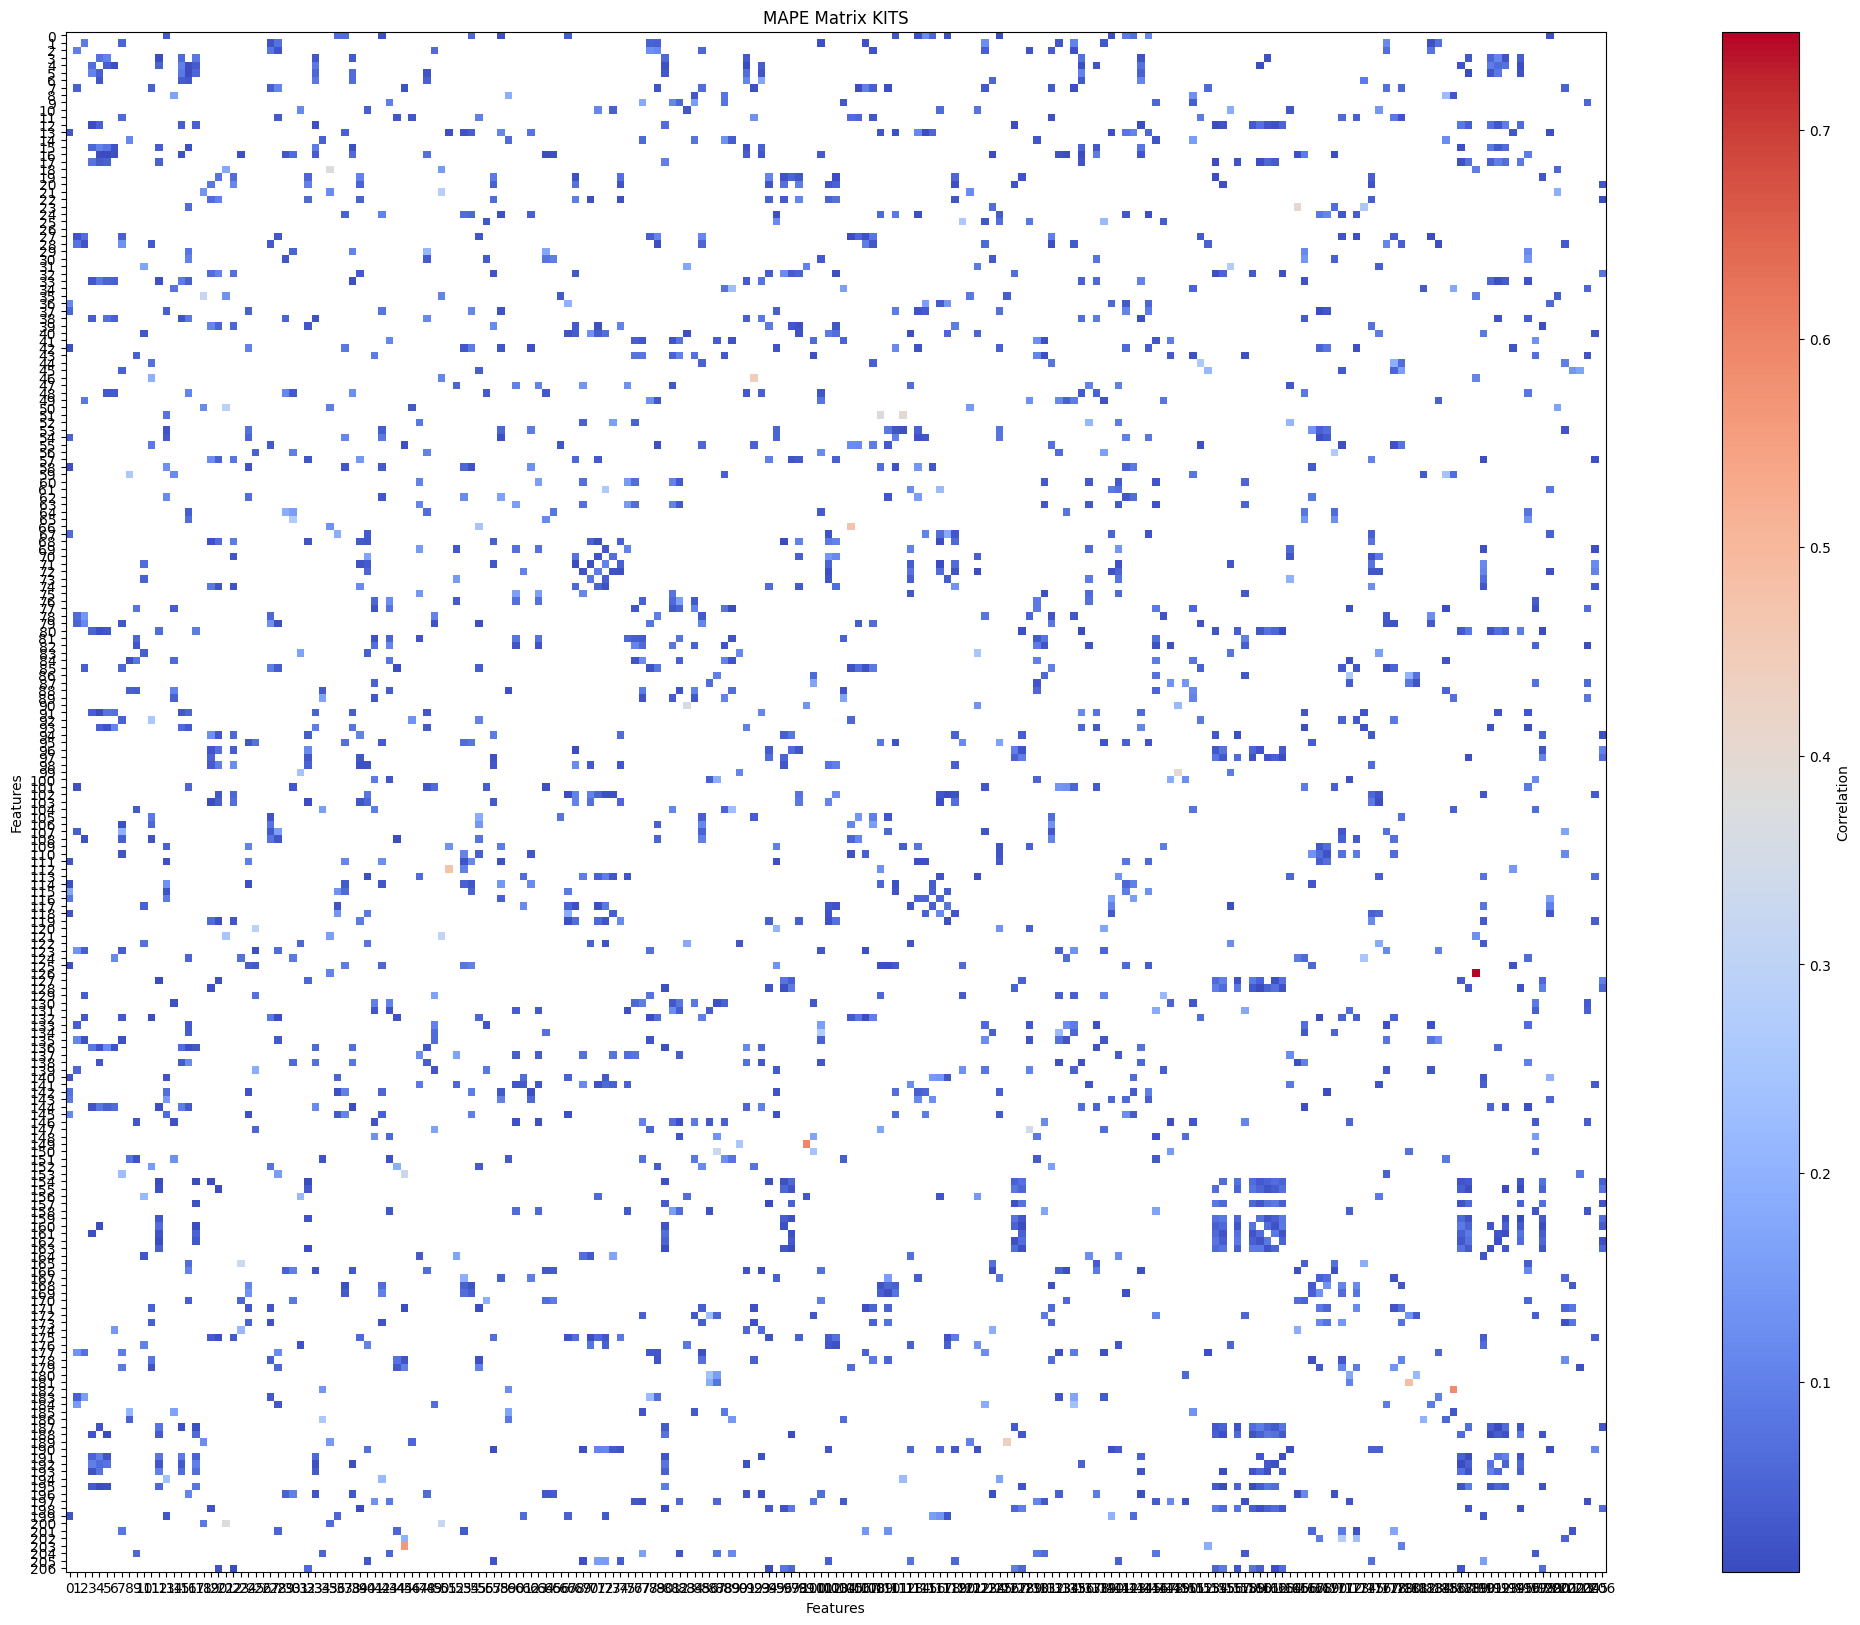

In [ ]:
preds = nx.google_matrix(nx_g3)

jacc_coeff = preds

jacc_coeff = np.where(adj > 0, jacc_coeff, np.zeros_like(jacc_coeff)*(-np.inf))

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(jacc_coeff, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# Add text annotations
# for i in range(mape_mat.shape[0]):
#     for j in range(mape_mat.shape[1]):
#         plt.text(j, i, f"{mape_mat[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("MAPE Matrix KITS")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(jacc_coeff.shape[0]))
plt.yticks(range(jacc_coeff.shape[1]))
plt.show()

(207, 6849)


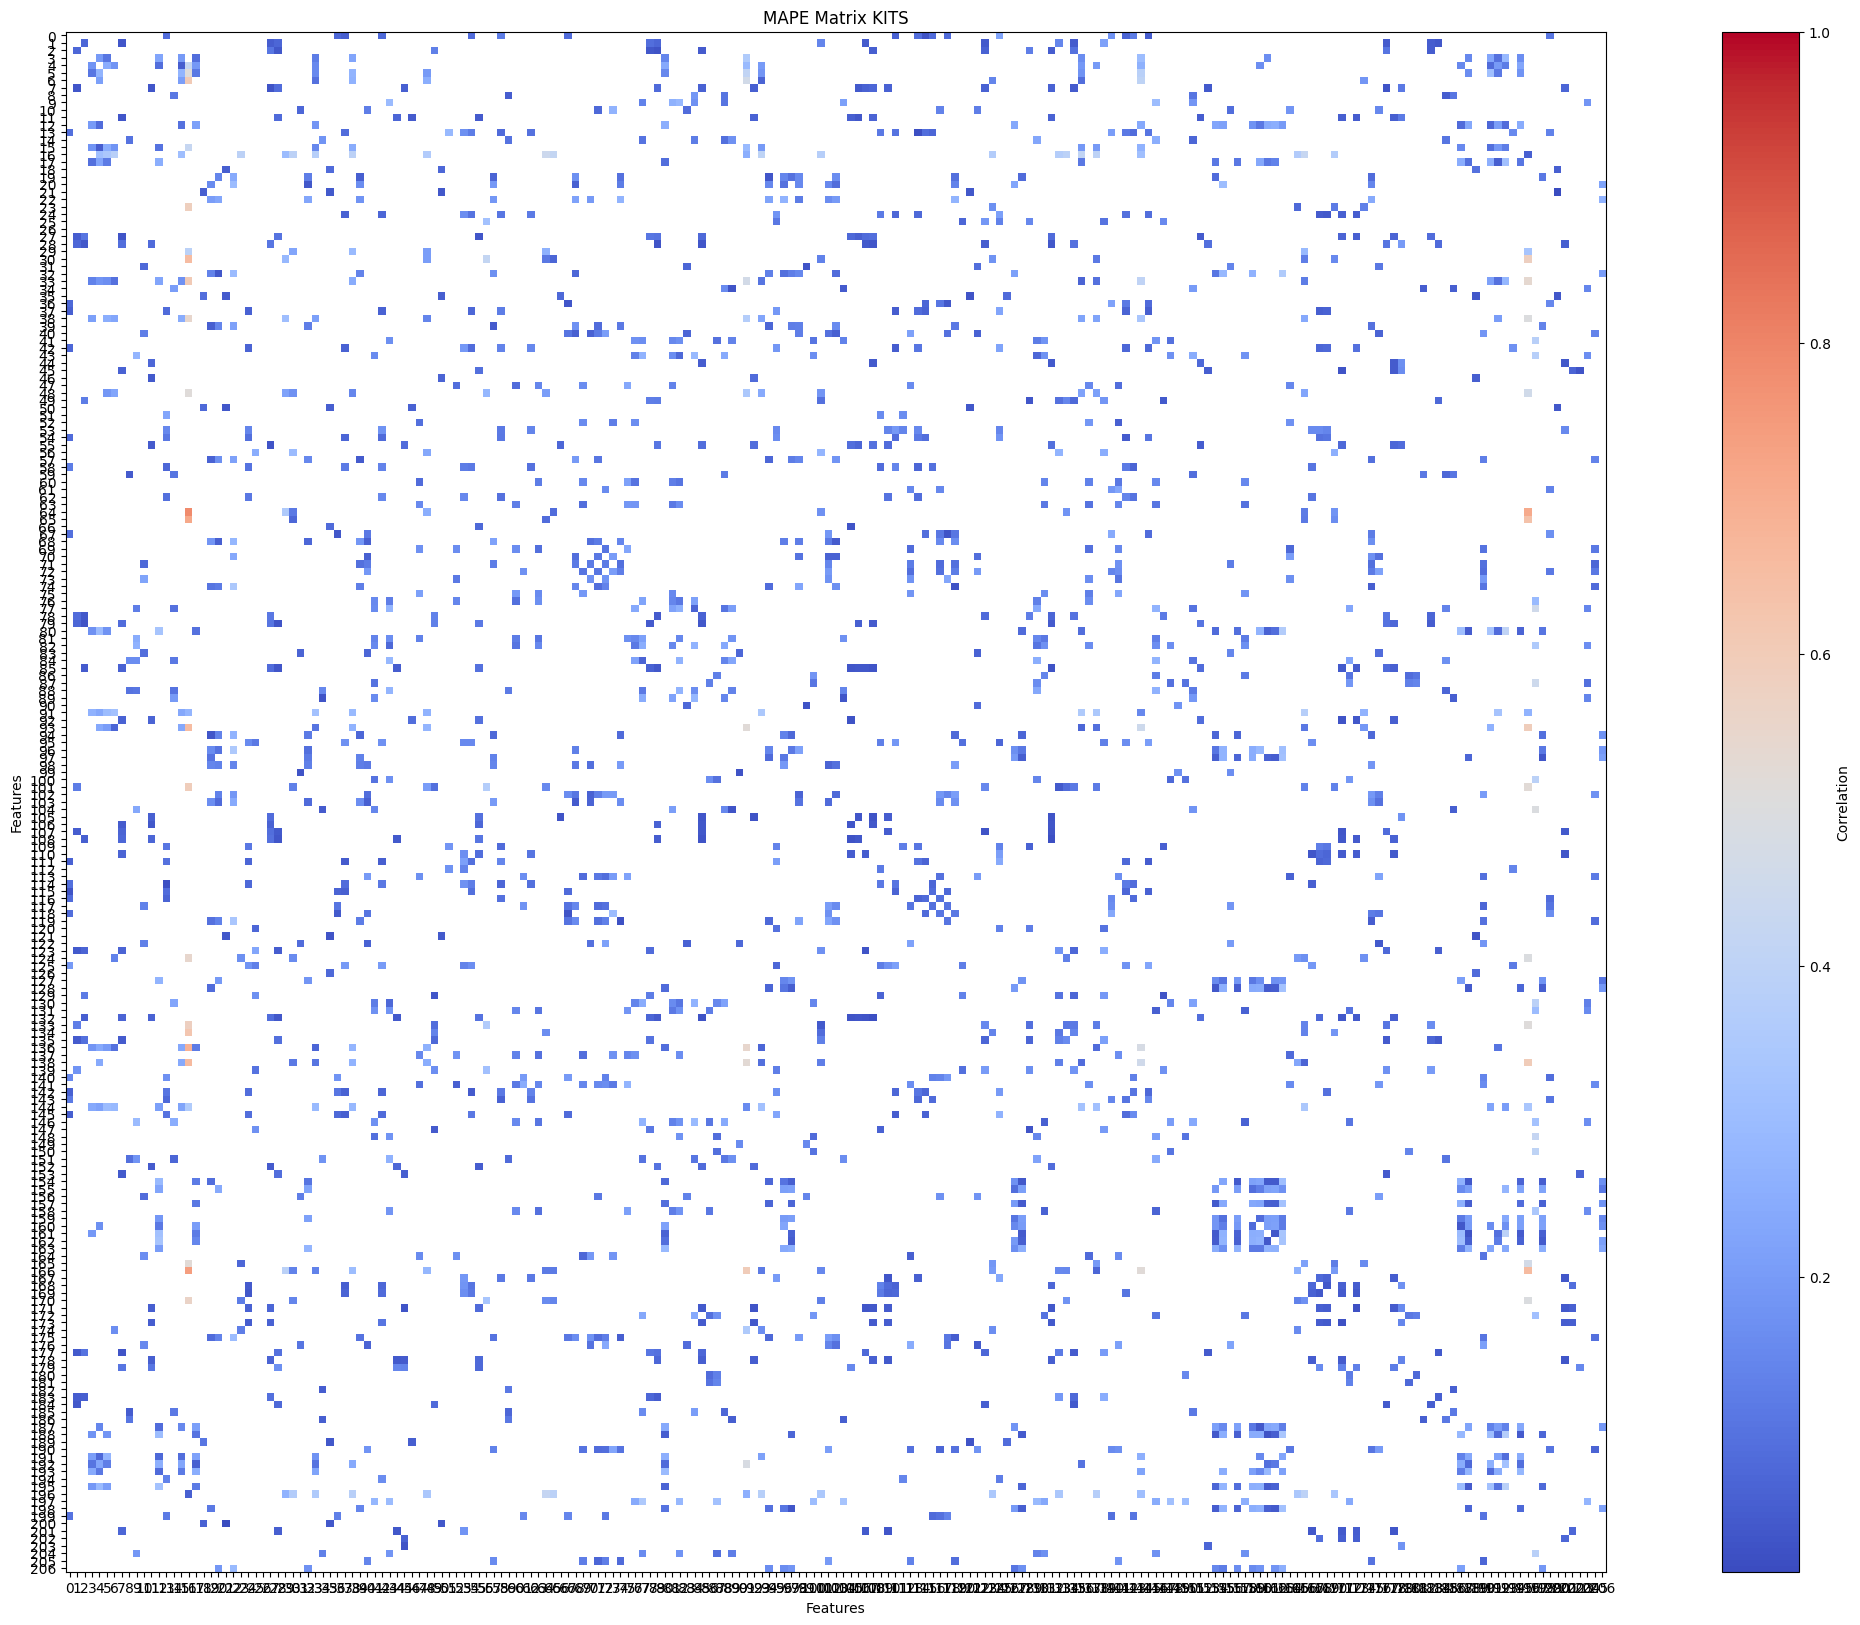

In [ ]:
features_raw = deets[0][0][:, 0, :, 0].T

# features_raw = features_raw[1:, :] - features_raw[:-1, :]

# features_raw = deets[0][5].dataframe().values.T
print(features_raw.shape)

mape_mat = np.zeros((features_raw.shape[0], features_raw.shape[0]))
for i in range(features_raw.shape[0]):
    for j in range(features_raw.shape[0]):
        mape_mat[i, j] = numpy_metrics.mre(features_raw[i], features_raw[j])

mape_mat = np.where(adj > 0, mape_mat, np.zeros_like(mape_mat)*(-np.inf))

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(mape_mat, cmap="coolwarm", interpolation="nearest", vmax=1)
plt.colorbar(label="Correlation")

# Add text annotations
# for i in range(mape_mat.shape[0]):
#     for j in range(mape_mat.shape[1]):
#         plt.text(j, i, f"{mape_mat[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("MAPE Matrix KITS")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(mape_mat.shape[0]))
plt.yticks(range(mape_mat.shape[1]))
plt.show()

In [ ]:
masks = torch.where(torch.sum(torch.tensor(deets[0][2]), dim=(0, 1, 3)) > 0)
masks[0]

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
torch.cat([masks, masks_o]), masks, masks_o

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]),
 tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 tensor([ 0, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
         29, 30, 31, 32, 33, 34, 35]))

In [72]:
adj.shape

(36, 36)

In [87]:
whut = torch.tensor([5., 5., 5., 5., float('-inf')])
whut1 = torch.tensor([2., 4., 5., 6., float('inf')])
torch.nn.functional.softmax(whut), torch.nn.functional.softmax(-whut1)

(tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.0000]),
 tensor([0.8310, 0.1125, 0.0414, 0.0152, 0.0000]))

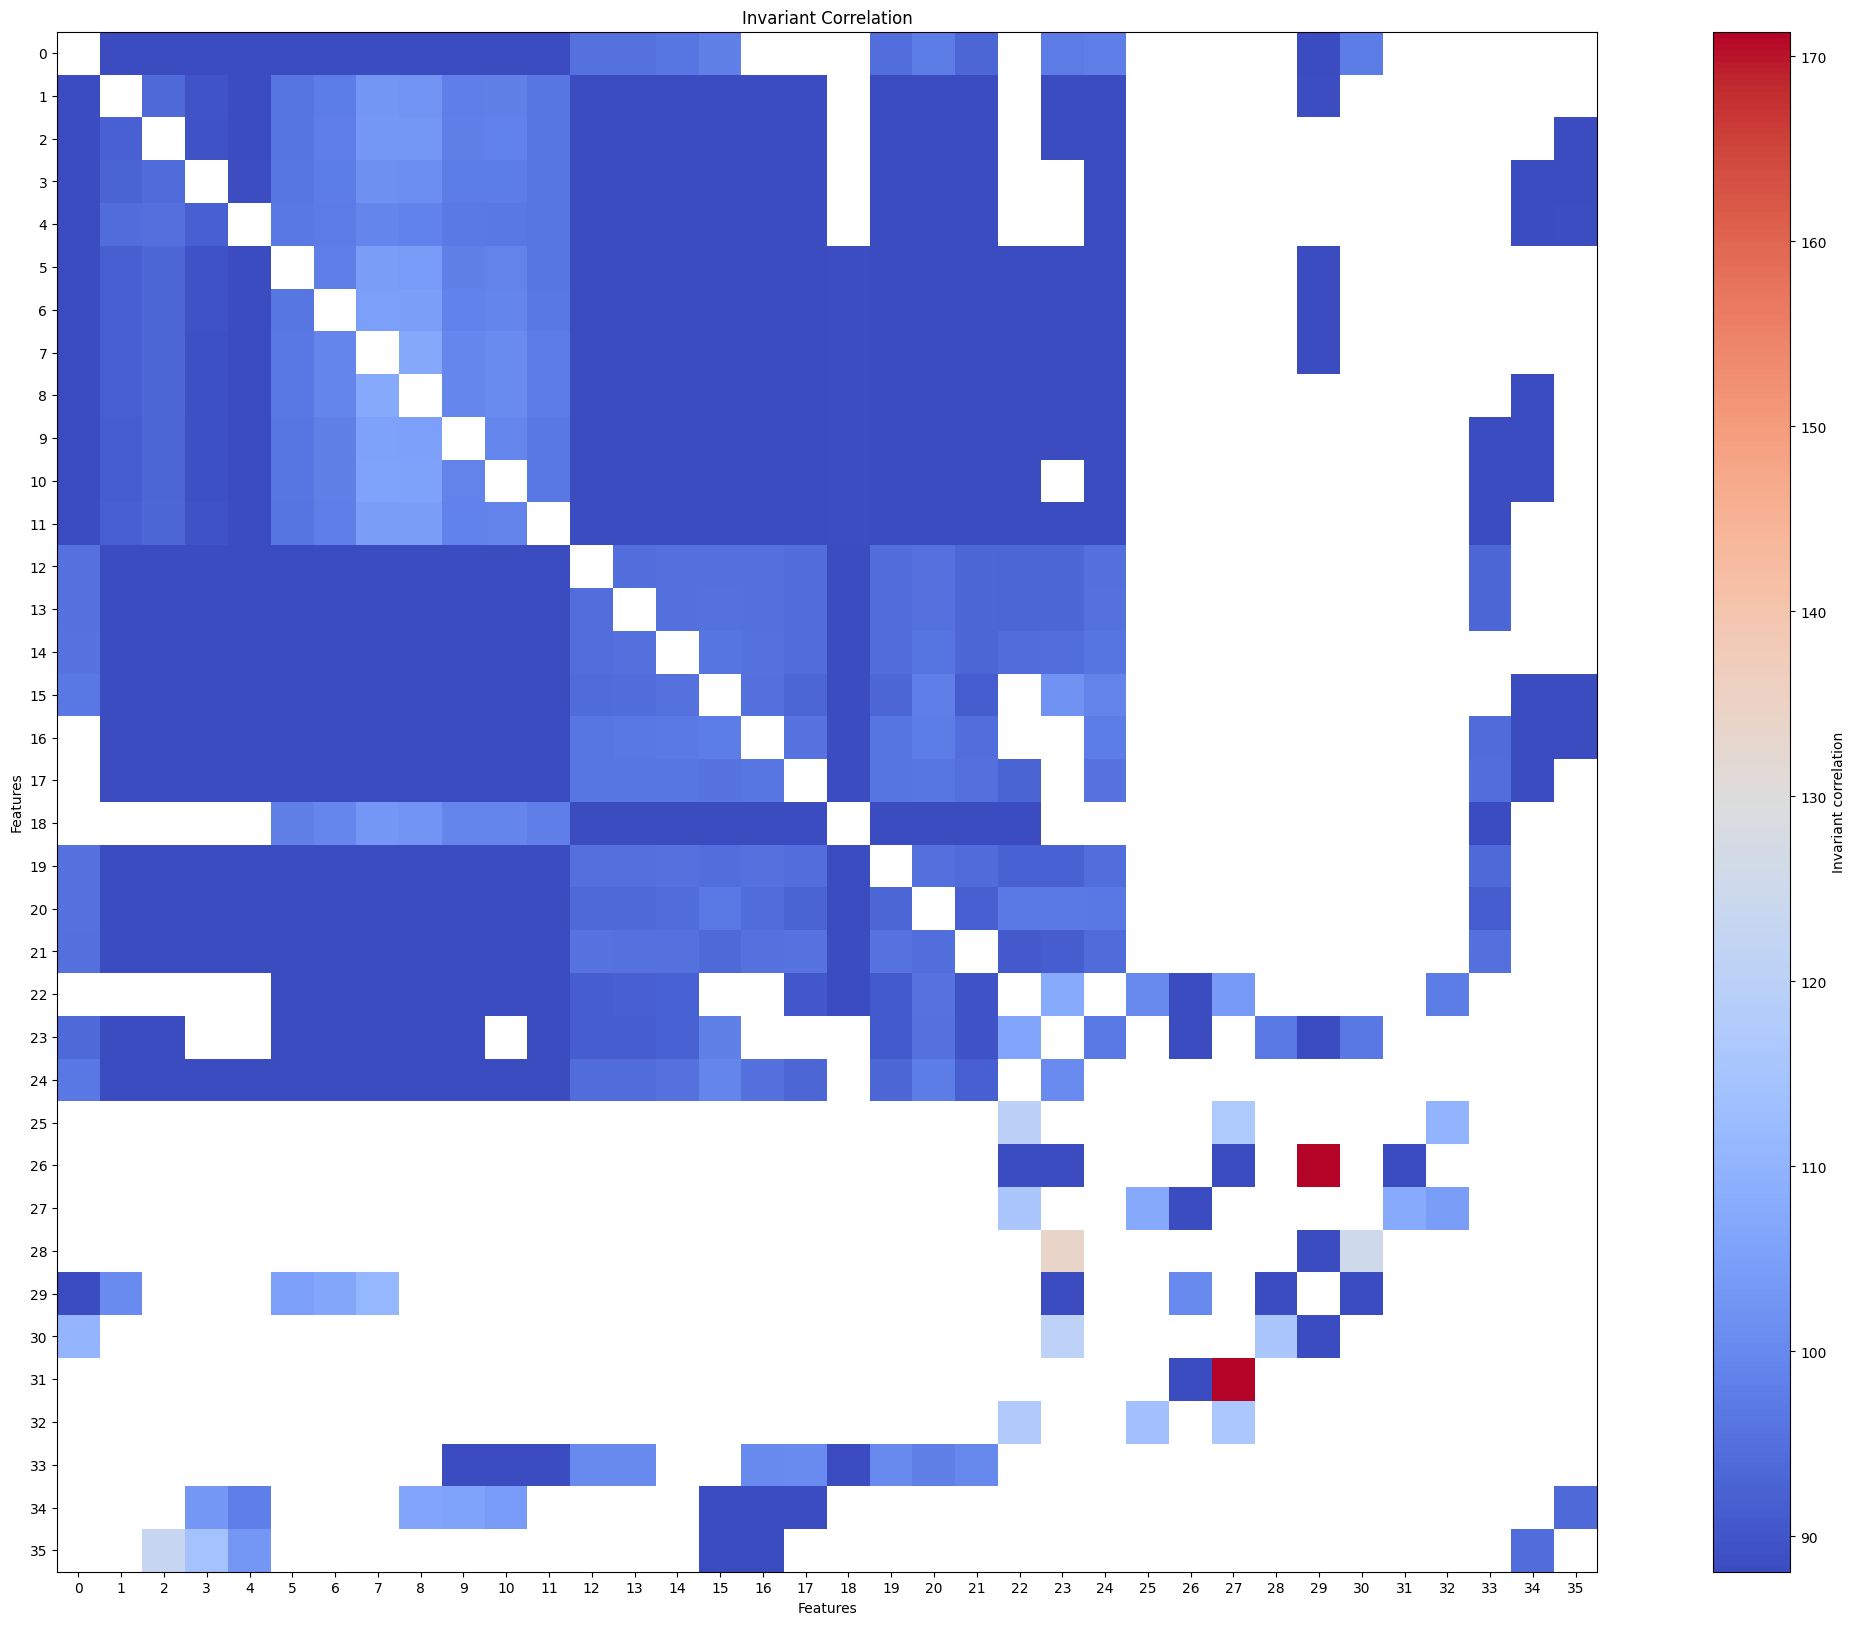

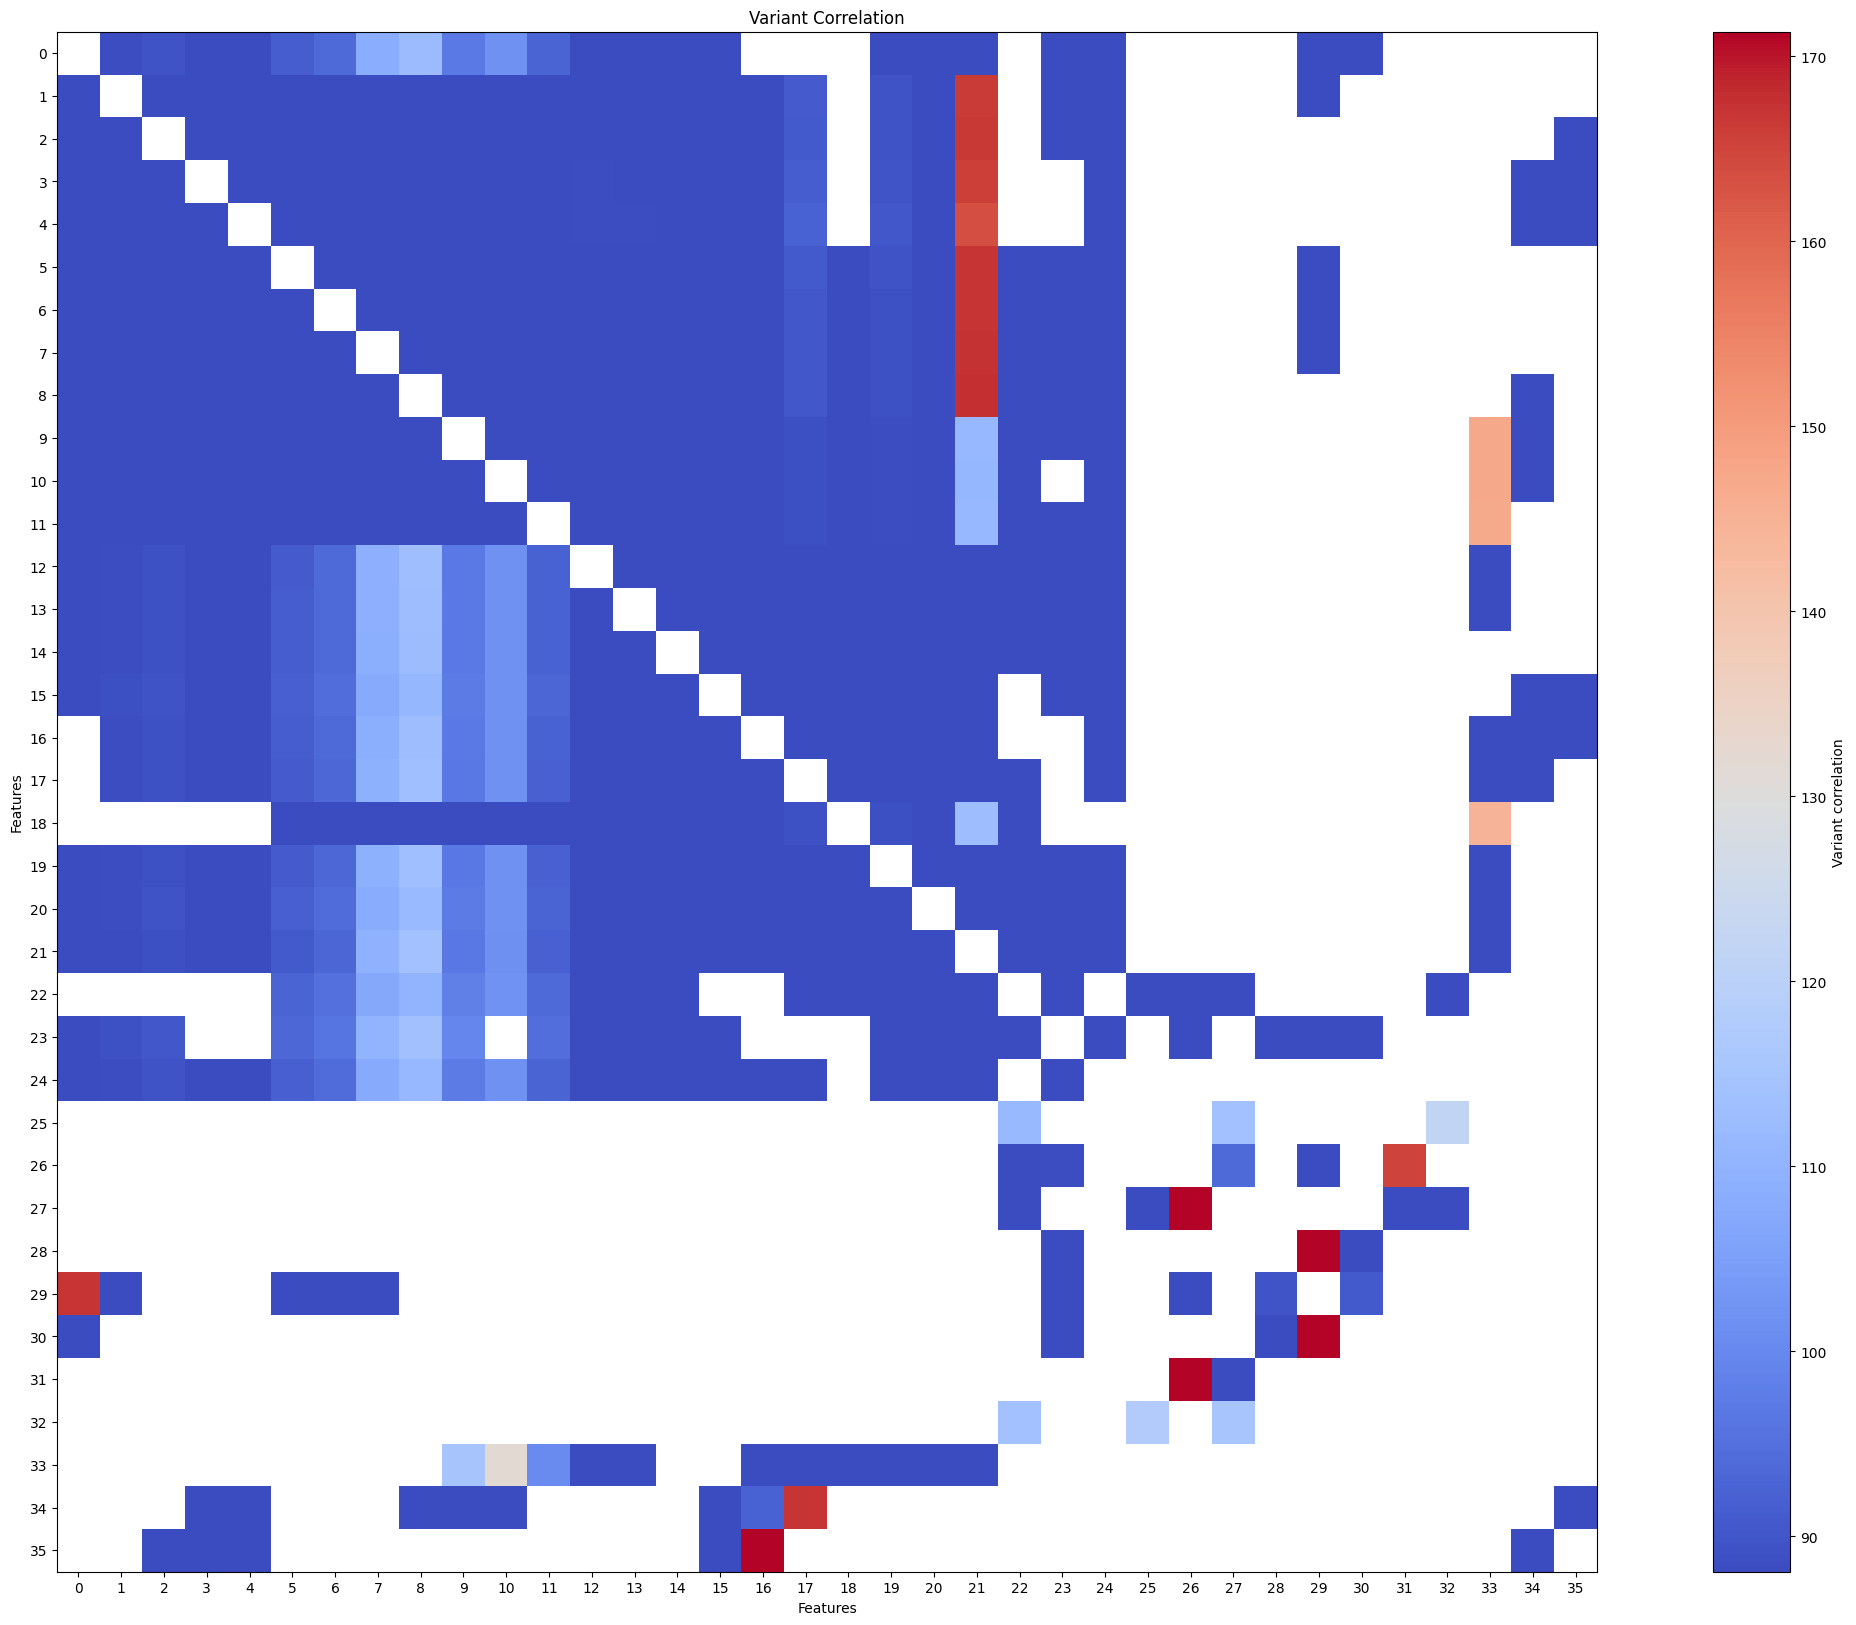

In [77]:
inv = deets[0][9][:, 0, :, :]
var = deets[0][10][:, 0, :, :]
ind = 0

invs = np.where(adj > 0, inv, np.ones_like(inv)*(np.nan))[ind]
vars = np.where(adj > 0, var, np.ones_like(var)*(np.nan))[ind]

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(invs, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Invariant correlation")

# Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Invariant Correlation")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(invs.shape[0]))
plt.yticks(range(invs.shape[1]))
plt.show()

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(vars, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Variant correlation")

# Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Variant Correlation")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(vars.shape[0]))
plt.yticks(range(vars.shape[1]))
plt.show()

In [ ]:
features_raw = deets[0]
masks = torch.where(torch.sum(torch.tensor(features_raw[2]), dim=(0, 1, 3)) > 0)[0]
masks_o = torch.where(torch.sum(torch.tensor(features_raw[2]), dim=(0, 1, 3)) == 0)[0]
fin_mask = torch.cat([masks_o, masks])

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
0.37692277673033503
47.146492
-211.52130065754744


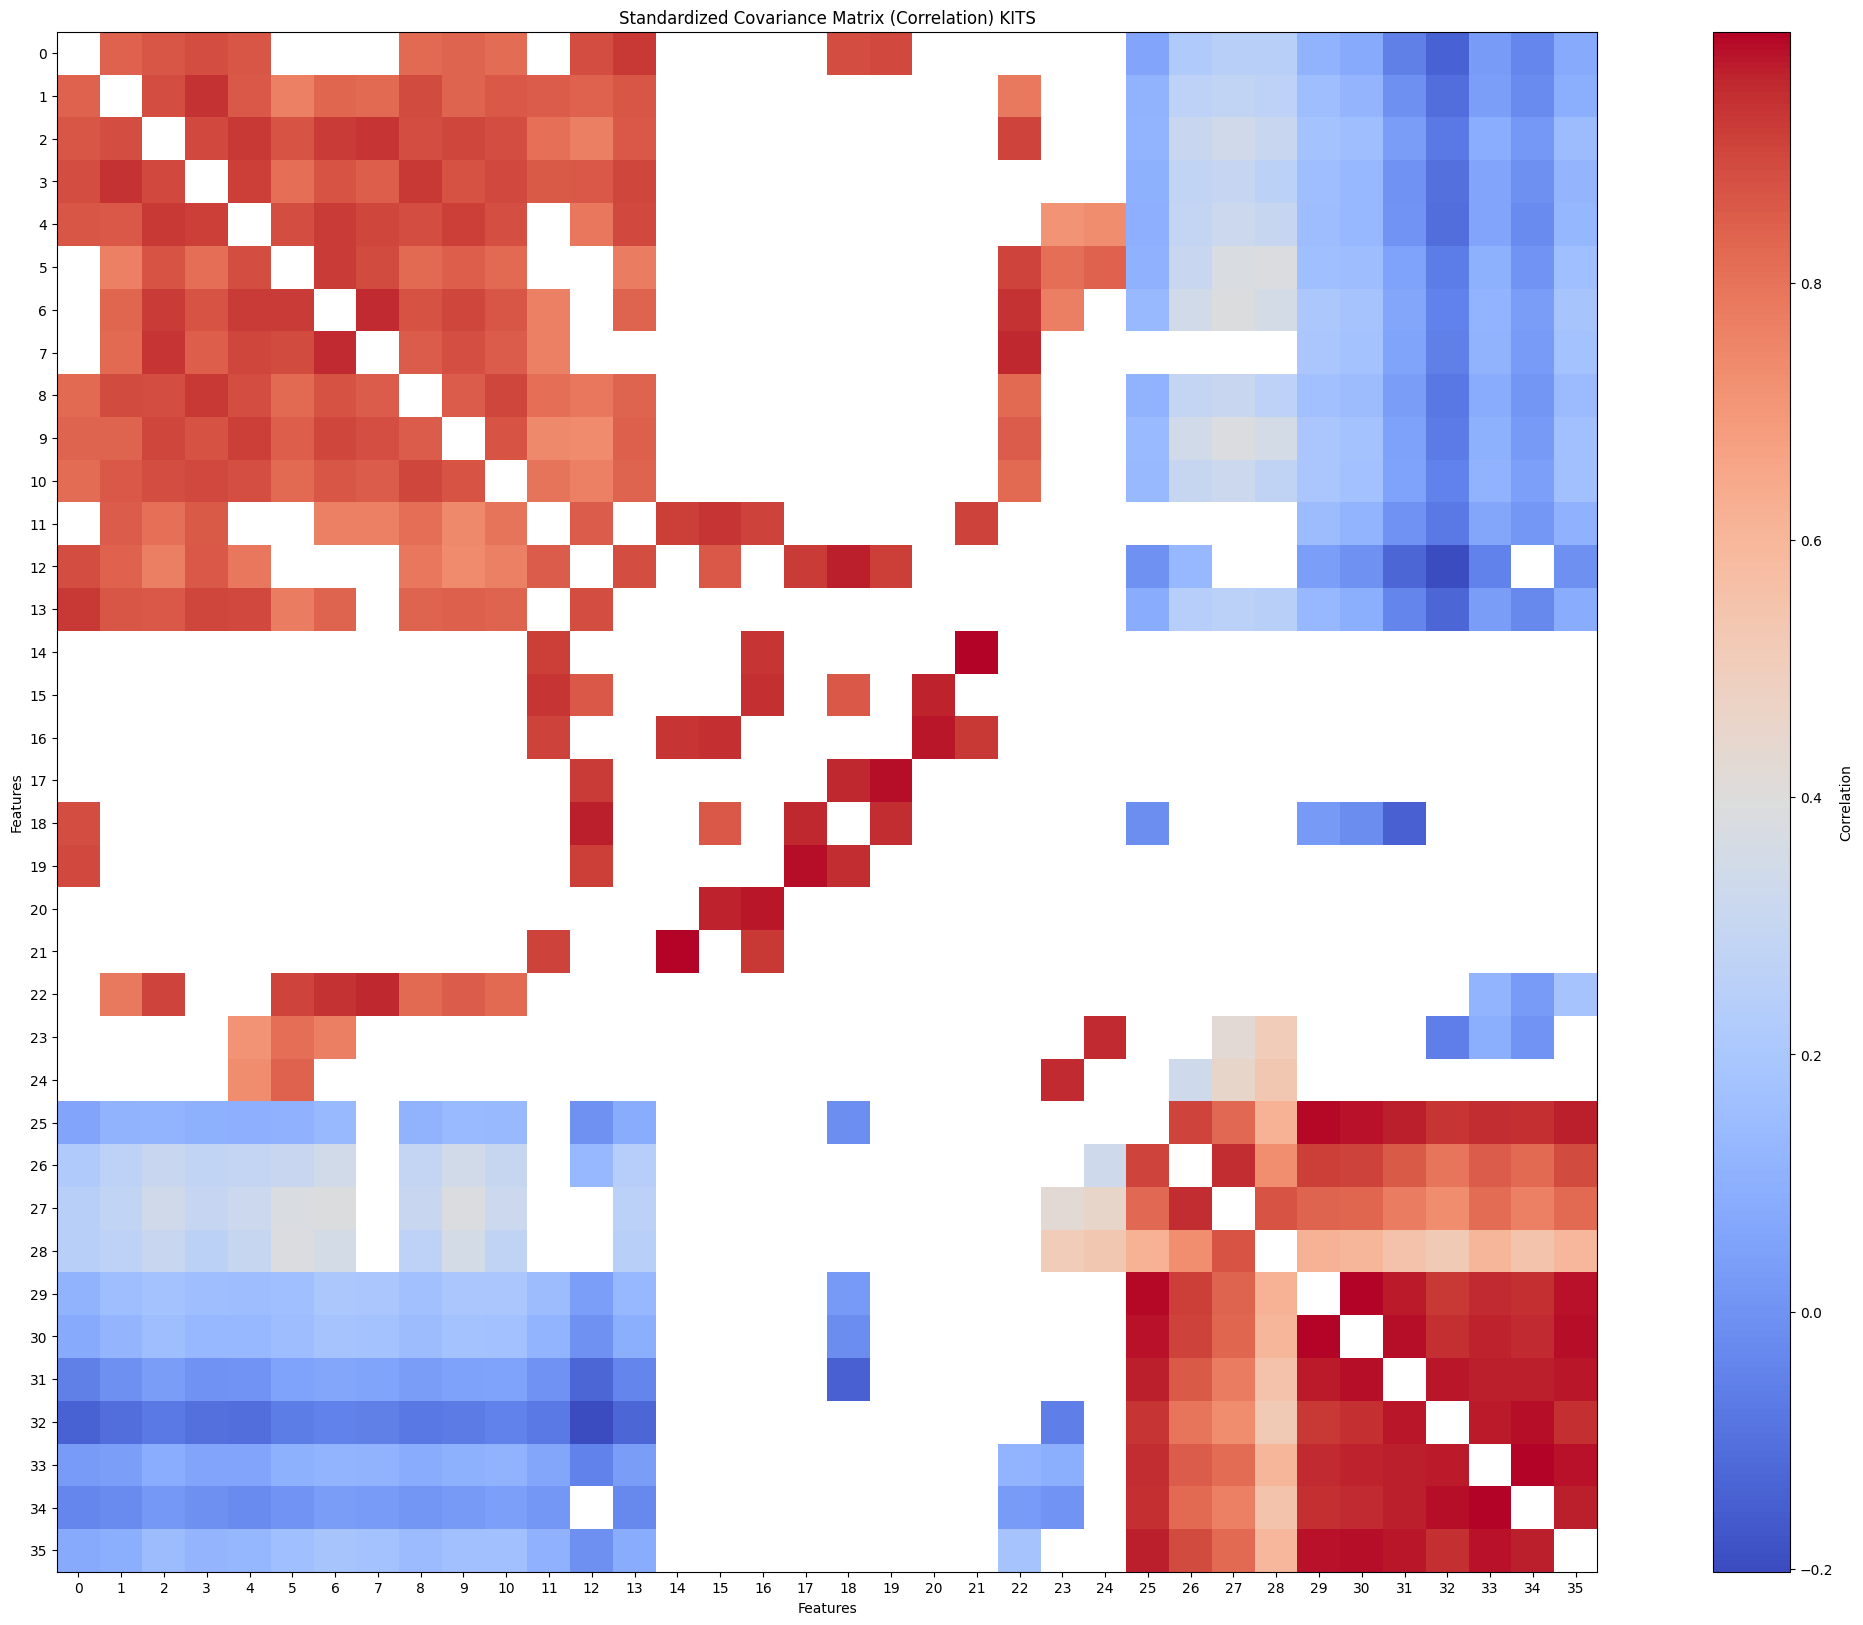

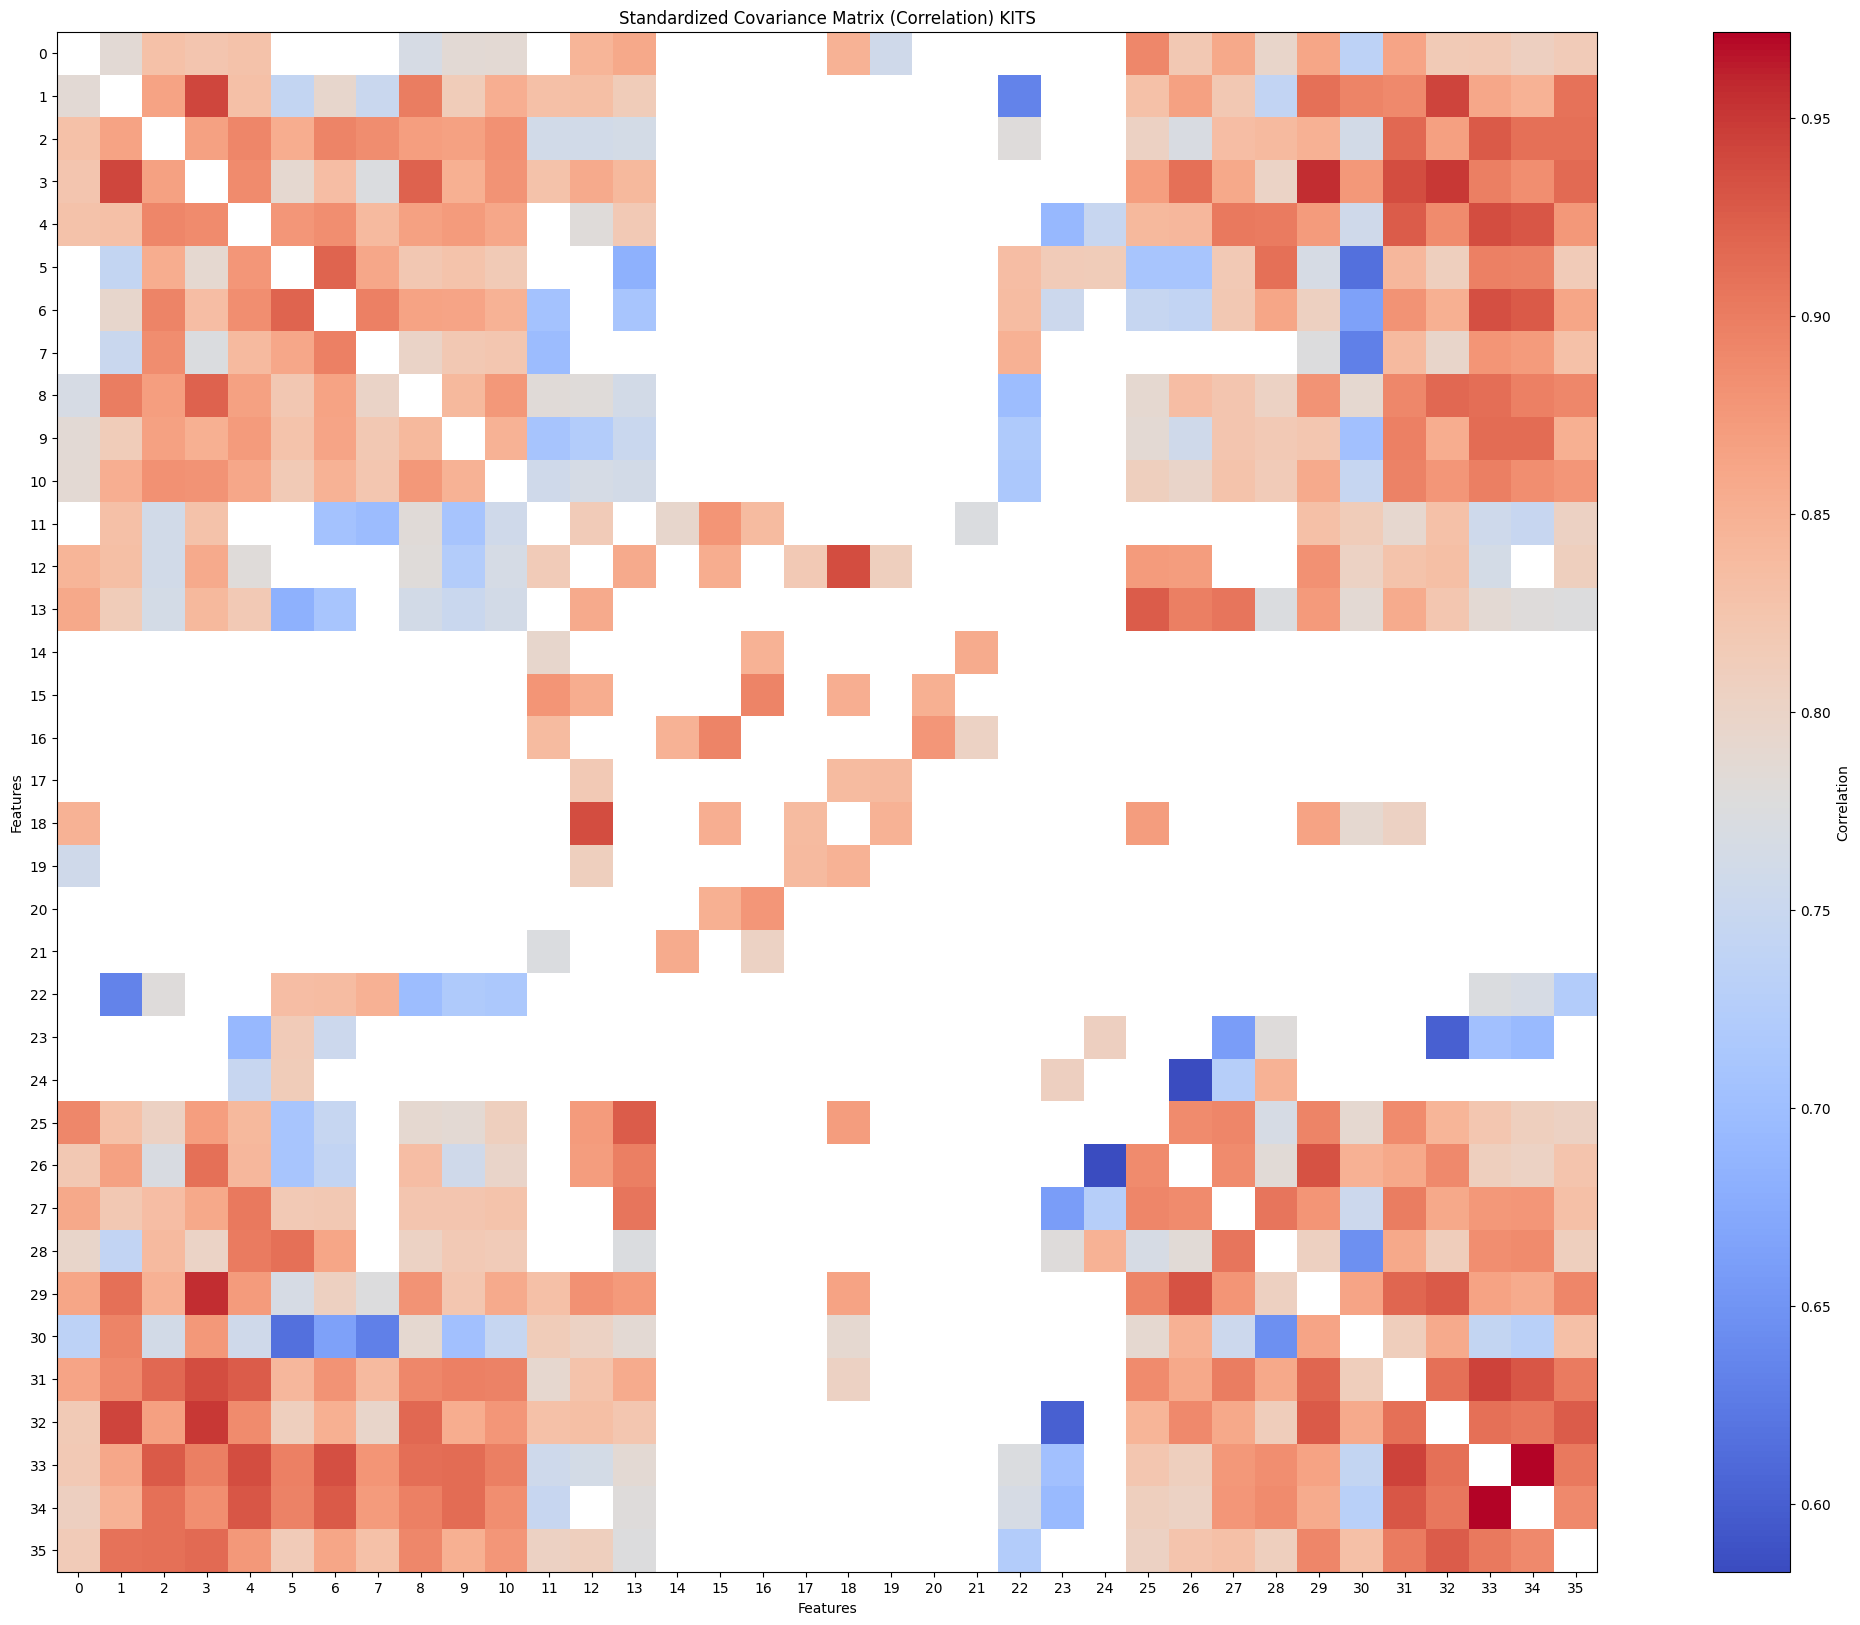

In [ ]:
features_raw = deets[0]
masks = torch.where(torch.sum(torch.tensor(features_raw[2]), dim=(0, 1, 3)) > 0)[0]
masks_o = torch.where(torch.sum(torch.tensor(features_raw[2]), dim=(0, 1, 3)) == 0)[0]
fin_mask = torch.cat([masks_o, masks])

print(masks)
# features_raw = features_raw[1:, :] - features_raw[:-1, :]

# Prediction
cov_mat = np.cov(features_raw[0][:, 0, :, 0], rowvar=False, bias=False)

std_devs = np.sqrt(np.diag(cov_mat))
std_dev_outer = np.outer(std_devs, std_devs)

standardized_cov_matrix = np.divide(cov_mat, std_dev_outer, where=std_dev_outer != 0)

standardized_cov_matrix = np.where(adj > 0, standardized_cov_matrix, np.ones_like(standardized_cov_matrix)*(np.nan))

# True
cov_mat = np.cov(features_raw[1][:, 0, :, 0], rowvar=False, bias=False)

std_devs = np.sqrt(np.diag(cov_mat))
std_dev_outer = np.outer(std_devs, std_devs)

standardized_cov_matrix_true = np.divide(cov_mat, std_dev_outer, where=std_dev_outer != 0)

standardized_cov_matrix_true = np.where(adj > 0, standardized_cov_matrix_true, np.ones_like(standardized_cov_matrix_true)*(np.nan))

# Mask
standardized_cov_matrix = standardized_cov_matrix[:, fin_mask]
standardized_cov_matrix = standardized_cov_matrix[fin_mask, :]

standardized_cov_matrix_true = standardized_cov_matrix_true[:, fin_mask]
standardized_cov_matrix_true = standardized_cov_matrix_true[fin_mask, :]

m_adj = adj[:, fin_mask]
m_adj = m_adj[fin_mask, :]

preds = features_raw[0][:, :, masks]
phats = features_raw[1][:, :, masks]

print(numpy_metrics.mae(standardized_cov_matrix_true, standardized_cov_matrix, m_adj))
print(numpy_metrics.mae(preds, phats))
print(np.nansum(standardized_cov_matrix) - np.nansum(standardized_cov_matrix_true))

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(standardized_cov_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Standardized Covariance Matrix (Correlation) KITS")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(standardized_cov_matrix.shape[0]))
plt.yticks(range(standardized_cov_matrix.shape[1]))
plt.show()

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(standardized_cov_matrix_true, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Standardized Covariance Matrix (Correlation) KITS")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(standardized_cov_matrix_true.shape[0]))
plt.yticks(range(standardized_cov_matrix_true.shape[1]))
plt.show()

(tensor([  1,   2,   7,  10,  11,  27,  28,  29,  30,  31,  44,  45,  46,  48,
         49,  51,  53,  55,  58,  62,  64,  65,  66,  67,  71,  78,  79,  85,
         89,  90,  92,  96,  99, 104, 105, 106, 107, 108, 109, 110, 112, 114,
        118, 122, 123, 125, 129, 132, 135, 139, 147, 149, 152, 153, 156, 166,
        167, 170, 171, 173, 177, 178, 179, 183, 184, 194, 196, 201, 202]),)
6.322294


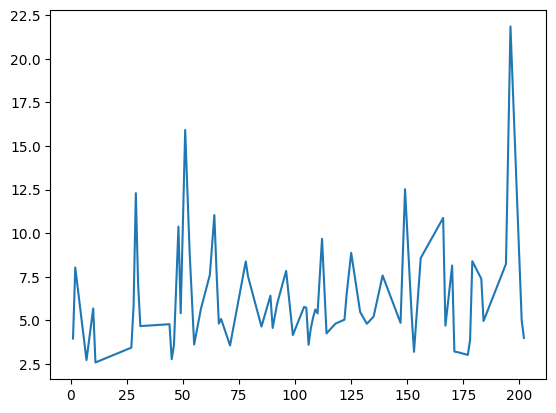

(tensor([  8,   9,  10,  18,  21,  23,  25,  26,  29,  31,  34,  35,  36,  44,
         45,  46,  47,  50,  51,  52,  56,  59,  61,  62,  64,  65,  66,  75,
         83,  86,  90,  92,  99, 100, 104, 106, 112, 116, 120, 121, 124, 126,
        129, 134, 143, 147, 148, 149, 150, 152, 153, 156, 164, 165, 170, 174,
        180, 181, 182, 183, 184, 185, 186, 189, 194, 200, 201, 202, 203]),)
6.5107884


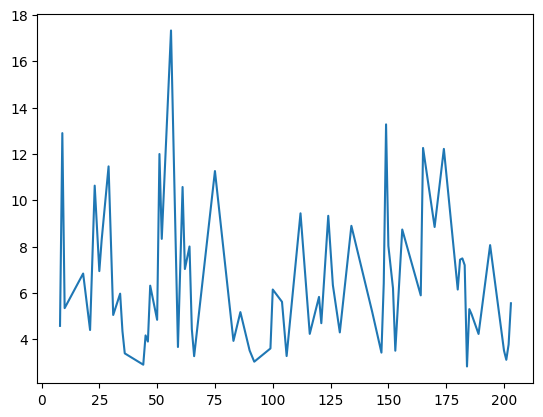

(tensor([  0,   3,   4,   5,   7,  12,  13,  15,  16,  17,  19,  20,  22,  24,
         27,  28,  32,  33,  40,  42,  43,  68,  71,  72,  77,  79,  80,  82,
         85,  91,  96,  97, 102, 103, 111, 117, 119, 125, 127, 128, 132, 136,
        138, 141, 142, 144, 146, 154, 155, 157, 159, 160, 161, 162, 163, 166,
        171, 175, 187, 188, 190, 191, 192, 193, 195, 196, 197, 198, 206]),)
9.013969


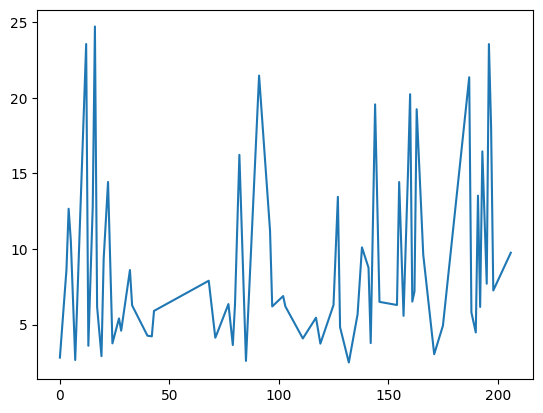

(tensor([  1,   2,   6,  11,  14,  30,  37,  38,  39,  41,  48,  49,  53,  54,
         55,  57,  58,  60,  63,  67,  69,  70,  73,  74,  76,  78,  81,  84,
         87,  88,  89,  93,  94,  95,  98, 101, 105, 107, 108, 109, 110, 113,
        114, 115, 118, 122, 123, 130, 131, 133, 135, 137, 139, 140, 145, 151,
        158, 167, 168, 169, 172, 173, 176, 177, 178, 179, 199, 204, 205]),)
6.0549407


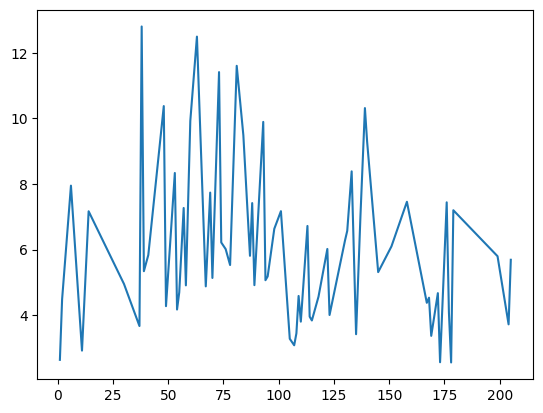

In [ ]:
features_raw = deets[1]
for features_raw in [deets[0], deets[1], deets[2], deets[3]]:
    masks = torch.where(torch.sum(torch.tensor(features_raw[2]), dim=(0, 1, 3)) > 0)
    print(masks)

    # features_raw = features_raw[1:, :] - features_raw[:-1, :]

    # features_raw = deets[0][5].dataframe().values.T
    preds = features_raw[0][:, :, masks[0]]
    phats = features_raw[1][:, :, masks[0]]

    m_adj = adj[:, masks[0]]
    m_adj = m_adj[masks[0], :]

    mape_mat = []
    for i in range(preds.shape[2]):
        mape_mat.append(numpy_metrics.mae(preds[:, :, i], phats[:, :, i]))

    print(sum(mape_mat)/len(mape_mat))
    plt.plot(masks[0], mape_mat)
    plt.show()


In [ ]:
standardized_cov_matrix_true

array([[      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [      -inf,       -inf, 0.5138956 , ...,       -inf,       -inf,
              -inf],
       [      -inf, 0.5138956 ,       -inf, ...,       -inf,       -inf,
              -inf],
       ...,
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
        0.40862054],
       [      -inf,       -inf,       -inf, ...,       -inf, 0.40862054,
              -inf]])

In [ ]:
standardized_cov_matrix, 

array([[      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [      -inf,       -inf, 0.97488783, ...,       -inf,       -inf,
              -inf],
       [      -inf, 0.97488783,       -inf, ...,       -inf,       -inf,
              -inf],
       ...,
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [      -inf,       -inf,       -inf, ...,       -inf,       -inf,
        0.99707787],
       [      -inf,       -inf,       -inf, ...,       -inf, 0.99707787,
              -inf]])

In [ ]:
from networkx.algorithms import approximation

approximation.average_clustering(nx_g1), approximation.average_clustering(nx_g2), approximation.average_clustering(nx_g3)

(0.598, 0.559, 0.544)

In [ ]:
# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(standardized_cov_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# Add text annotations
for i in range(standardized_cov_matrix.shape[0]):
    for j in range(standardized_cov_matrix.shape[1]):
        plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Standardized Covariance Matrix (Correlation)")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(standardized_cov_matrix.shape[0]))
plt.yticks(range(standardized_cov_matrix.shape[1]))
plt.show()

In [ ]:
y_hat.shape

In [ ]:
graph_hat = y_hat.reshape(y_hat.shape[0]*y_hat.shape[1], y_hat.shape[2], y_hat.shape[3])
graph_true = y_true.reshape(y_true.shape[0]*y_true.shape[1], y_true.shape[2], y_true.shape[3])

graph_hat = y_hat[:, 0, :, :]
graph_true = y_true[:, 0, :, :]

ranges = [0, 500]
indices = torch.where(torch.sum(dm.eval_mask, dim=0) > 0)[0]
sensors = ['Glen Eden','CBD','CBD','Browns Bay','Henderson','Mt. Albert']
indices = [3, 11, 12, 13, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
indices = list(range(36))

if len(indices) == 1:
    plt.figure(figsize=(15,7))
    plt.plot(graph_hat[ranges[0]:ranges[1], indices[0], 0], color='g', label='Prediction')
    plt.plot(graph_true[ranges[0]:ranges[1], indices[0], 0], label='True Value')
    plt.title(f'GRU, Sensor: {sensors[indices[0]]}')
    plt.legend()
    plt.show()

else:
    fig, axs = plt.subplots(9, 4, figsize=(47,36))

    for i, ax in enumerate(axs.flatten()):
        # ax.plot(graph_hat[ranges[0]:ranges[1], indices[i], 0], color='g', label='Prediction')
        ax.plot(graph_true[ranges[0]:ranges[1], indices[i], 0])#, label='True Value')
        ax.set_title(f'Sensor: {indices[i]}')
        ax.legend()

    fig.suptitle('Dataset', y=.99)
    fig.tight_layout()
    plt.show()

In [ ]:
indices

In [ ]:
m = np.mean(y_true, axis=1)

In [ ]:
m.shape

In [ ]:
graph_true = y_true.reshape(y_true.shape[0]*y_true.shape[1], y_true.shape[2], y_true.shape[3])

In [ ]:
dm

In [ ]:
dm.torch_dataset.dataframe()

In [ ]:
np.array(dataset.df.iloc[2184:3671, 4])

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(np.array(dm.torch_dataset.dataframe().iloc[2184:2184+24, 4]))
plt.plot(y_true[1, :, 4, :])
plt.show()

In [ ]:
y_hat.shape

In [ ]:
dm.torch_dataset

In [ ]:
dm.test_dataloader()

In [ ]:
dm.mask

In [ ]:
torch.where(torch.sum(dm.eval_mask, dim=0) > 0)

In [ ]:
torch.sum(dm.mask[:, 5, :])

In [ ]:
y_hat.shape